In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
import pandas as pd
from scipy.stats import expon
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
import seaborn as sns
from copulas.multivariate import GaussianMultivariate
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import warnings
import numpy as np

In [2]:
#nomi delle colonne da generare
columns_to_generate = [
    'Durata','CabEnabled_M1', 'CabEnabled_M8', 'ERTMS_PiastraSts', 'HMI_ACPntSts_T2', 'HMI_ACPntSts_T7', 'HMI_DCPntSts_T2',
    'HMI_DCPntSts_T7', 'HMI_Iline', 'HMI_Irsts_T2', 'HMI_Irsts_T7', 'HMI_VBatt_T2', 'HMI_VBatt_T4', 'HMI_VBatt_T5',
    'HMI_VBatt_T7', 'HMI_Vline', 'HMI_impSIL', 'LineVoltType', 'MDS_LedLimVel', 'MDS_StatoMarcia', '_GPS_LAT',
    '_GPS_LON', 'ldvvelimps', 'ldvveltreno', 'usB1BCilPres_M1', 'usB1BCilPres_M3', 'usB1BCilPres_M6', 'usB1BCilPres_M8',
    'usB1BCilPres_T2', 'usB1BCilPres_T4', 'usB1BCilPres_T5', 'usB1BCilPres_T7', 'usB2BCilPres_M1', 'usB2BCilPres_M3',
    'usB2BCilPres_M6', 'usB2BCilPres_M8', 'usB2BCilPres_T2', 'usB2BCilPres_T4', 'usB2BCilPres_T5', 'usB2BCilPres_T7',
    'usBpPres', 'usMpPres'
]

In [3]:
#unisco il dataset con le classificazioni
dataset = pd.read_csv('dataset.csv')

classifications = pd.read_csv('descrizioni_classificate.csv')

event_mapped = dict(zip(classifications['Descrizione'], classifications['Tipo_Evento']))

dataset['Tipo_Evento'] = dataset['Descrizione'].map(event_mapped)

dataset.to_csv('dataset_classificato.csv', index=False)

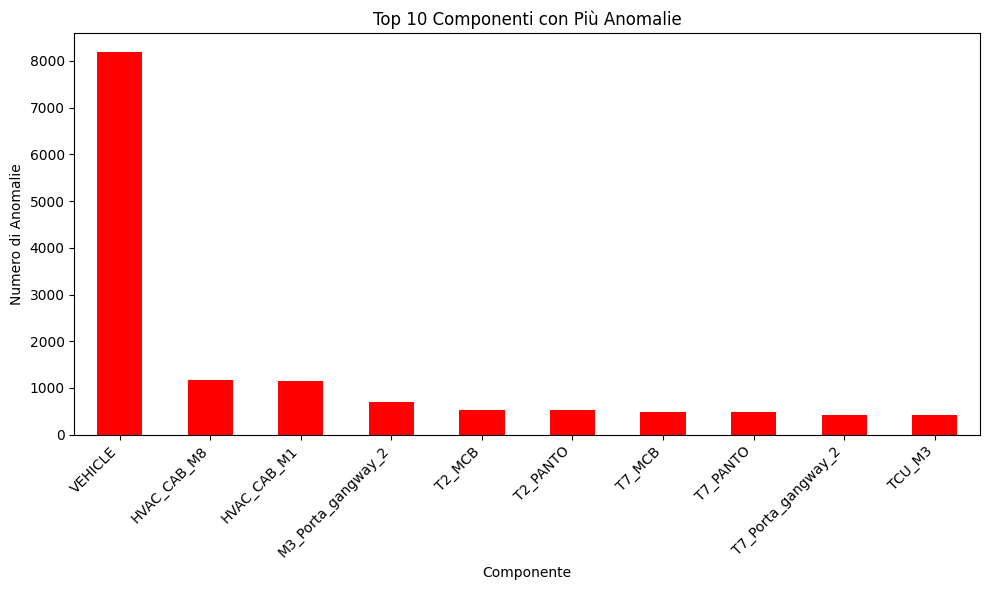

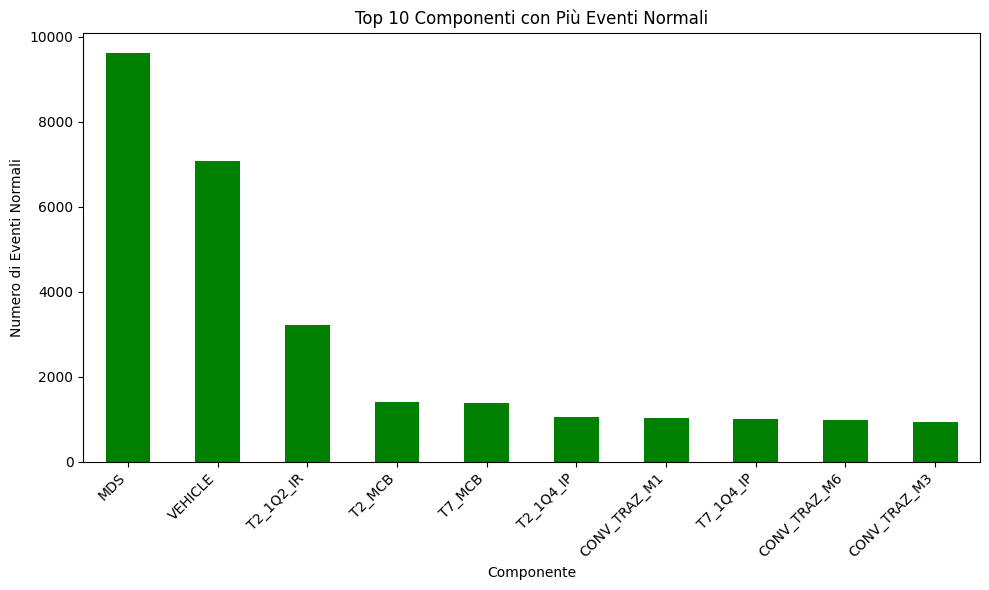

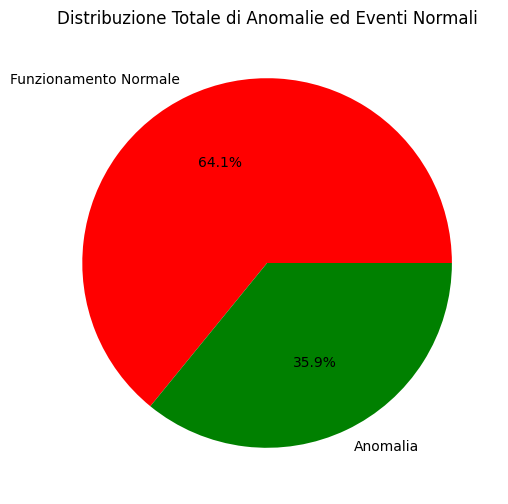

In [4]:
#rappresetaione grafica dei dati
if 'Componente' in dataset.columns and 'Tipo_Evento' in dataset.columns:

    eventi_per_componente = dataset.groupby(['Componente', 'Tipo_Evento']).size().unstack(fill_value=0)
    
    top_anomalies = eventi_per_componente['Anomalia'].nlargest(10)
    plt.figure(figsize=(10, 6))
    top_anomalies.plot(kind='bar', color='red')
    plt.title('Top 10 Componenti con Più Anomalie')
    plt.xlabel('Componente')
    plt.ylabel('Numero di Anomalie')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()
    
    top_normal_events = eventi_per_componente['Funzionamento Normale'].nlargest(10)
    plt.figure(figsize=(10, 6))
    top_normal_events.plot(kind='bar', color='green')
    plt.title('Top 10 Componenti con Più Eventi Normali')
    plt.xlabel('Componente')
    plt.ylabel('Numero di Eventi Normali')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()
    
    counts = dataset['Tipo_Evento'].value_counts()
    plt.figure(figsize=(6, 6))
    counts.plot(kind='pie', autopct='%1.1f%%', colors=['red', 'green'])
    plt.title('Distribuzione Totale di Anomalie ed Eventi Normali')
    plt.ylabel('')
    plt.show()

else:
    print("Le colonne 'Componente' e 'Tipo_Evento' devono essere presenti nel dataset per generare i grafici.")



In [5]:
#filtro il dataset per il componente VEHICLE e rimuovo le colonne vuote
print(f"Numero di righe prima del filtraggio: {dataset.shape[0]}")
print(f"Numero di colonne prima della rimozione di colonne vuote: {dataset.shape[1]}")

df_vehicle = dataset[dataset['Componente'] == 'VEHICLE']

df_vehicle_cleaned = df_vehicle.dropna(axis=1, how='all')

print(f"Numero di righe dopo il filtraggio: {df_vehicle_cleaned.shape[0]}")
print(f"Numero di colonne dopo la rimozione di colonne vuote: {df_vehicle_cleaned.shape[1]}")

Numero di righe prima del filtraggio: 57652
Numero di colonne prima della rimozione di colonne vuote: 170
Numero di righe dopo il filtraggio: 15277
Numero di colonne dopo la rimozione di colonne vuote: 58


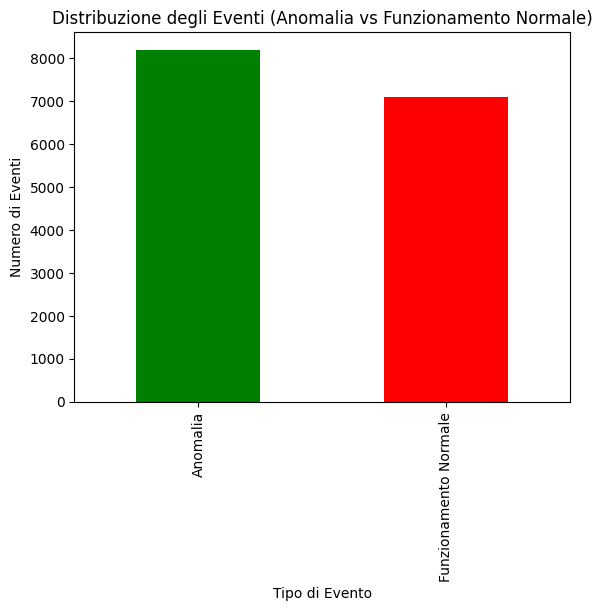

In [6]:
#visualizzazione della distribuzione degli eventi
event_type = df_vehicle_cleaned['Tipo_Evento'].value_counts()

event_type.plot(kind='bar', color=['green', 'red'])
plt.title('Distribuzione degli Eventi (Anomalia vs Funzionamento Normale)')
plt.xlabel('Tipo di Evento')
plt.ylabel('Numero di Eventi')
plt.show()

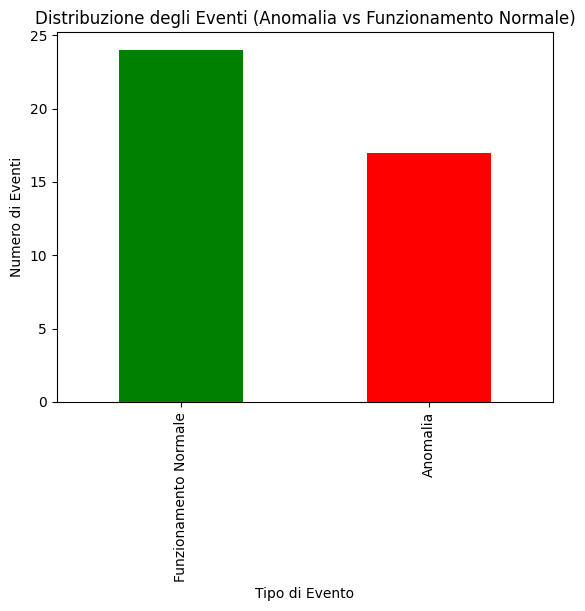

In [7]:
#visualizzazione della distribuzione degli eventi
df_unique_description = df_vehicle_cleaned[['Descrizione', 'Tipo_Evento']].drop_duplicates()

event_type = df_unique_description['Tipo_Evento'].value_counts()

event_type.plot(kind='bar', color=['green', 'red'])
plt.title('Distribuzione degli Eventi (Anomalia vs Funzionamento Normale)')
plt.xlabel('Tipo di Evento')
plt.ylabel('Numero di Eventi')
plt.show()

C:\Users\frogora\AppData\Local\Temp\ipykernel_16440\2534087197.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_vehicle_cleaned['Timestamp'] = pd.to_datetime(df_vehicle_cleaned['Timestamp'], errors='coerce')


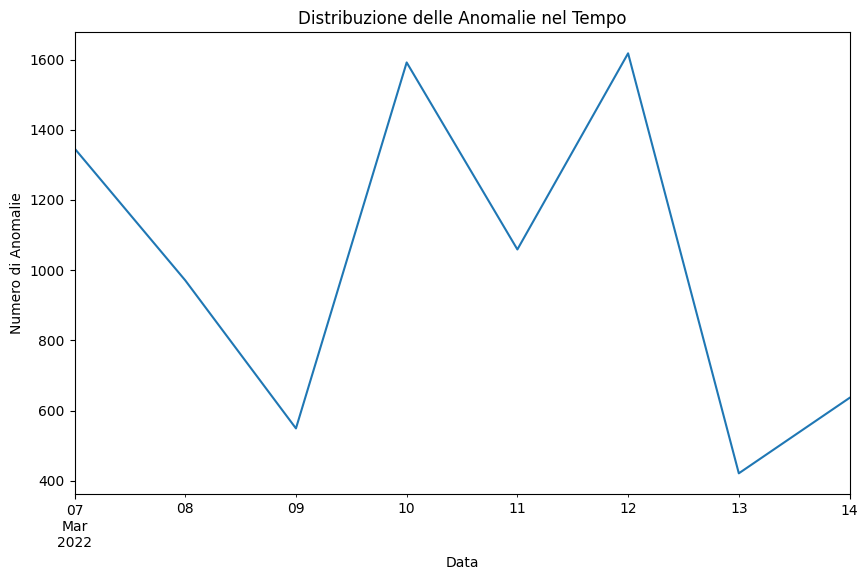

In [8]:
#visualizzazione della distribazione delle anomalie nel tempo
df_vehicle_cleaned['Timestamp'] = pd.to_datetime(df_vehicle_cleaned['Timestamp'], errors='coerce')

df_anomalie = df_vehicle_cleaned[df_vehicle_cleaned['Tipo_Evento'] == 'Anomalia'].dropna(subset=['Timestamp'])

df_anomalie.set_index('Timestamp', inplace=True)

df_anomalie.resample('D').size().plot(title='Distribuzione delle Anomalie nel Tempo', figsize=(10, 6))

plt.xlabel('Data')
plt.ylabel('Numero di Anomalie')
plt.show()

C:\Users\frogora\AppData\Local\Temp\ipykernel_16440\4133288278.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_vehicle_cleaned['Timestamp'] = pd.to_datetime(df_vehicle_cleaned['Timestamp'], errors='coerce')


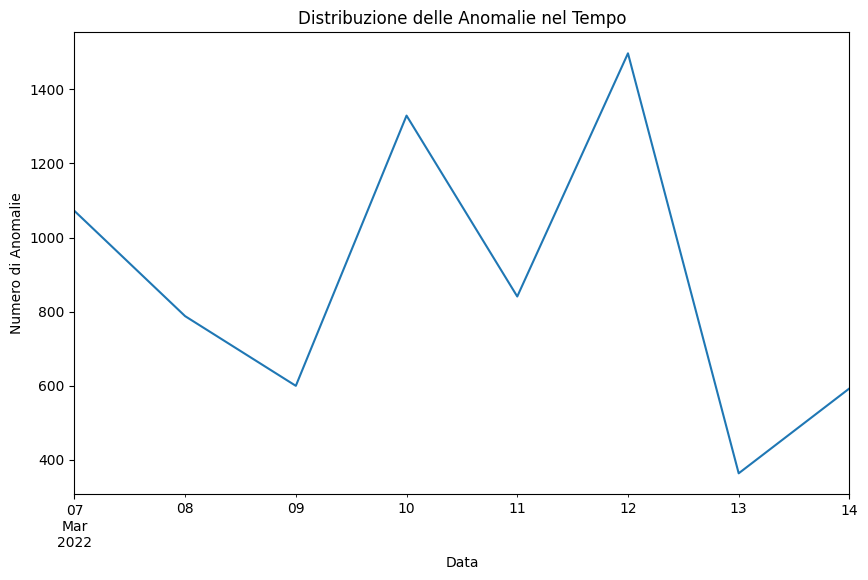

In [9]:
#visualizzazione della distribazione dei funzionamenti normali nel tempo
df_vehicle_cleaned['Timestamp'] = pd.to_datetime(df_vehicle_cleaned['Timestamp'], errors='coerce')

df_normali = df_vehicle_cleaned[df_vehicle_cleaned['Tipo_Evento'] == 'Funzionamento Normale'].dropna(subset=['Timestamp'])

df_normali.set_index('Timestamp', inplace=True)

df_normali.resample('D').size().plot(title='Distribuzione delle Anomalie nel Tempo', figsize=(10, 6))

plt.xlabel('Data')
plt.ylabel('Numero di Anomalie')
plt.show()

In [10]:
#aggiungo la colonna 'Tipo_Evento_Classificato' al dataset
df_vehicle_cleaned['Tipo_Evento_Classificato'] = df_vehicle_cleaned['Tipo_Evento'].apply(lambda x: 1 if x == 'Funzionamento Normale' else 0)

df_vehicle_cleaned.head()

C:\Users\frogora\AppData\Local\Temp\ipykernel_16440\907027636.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_vehicle_cleaned['Tipo_Evento_Classificato'] = df_vehicle_cleaned['Tipo_Evento'].apply(lambda x: 1 if x == 'Funzionamento Normale' else 0)


Flotta    Veicolo  Codice          Nome               Descrizione Test  \
2   ETR700  e700_4801  151014  _DCPantoSts_  Pantografo DC alto in T2    N   
3   ETR700  e700_4801  151014  _DCPantoSts_  Pantografo DC alto in T2    N   
4   ETR700  e700_4801  151014  _DCPantoSts_  Pantografo DC alto in T2    N   
38  ETR700  e700_4801  150007     _Standby_      Stato STANDBY attivo    N   
39  ETR700  e700_4801  150007     _Standby_      Stato STANDBY attivo    N   

                 Timestamp Timestamp chiusura  Durata Posizione  ...  \
2  2022-03-14 13:53:18.292                NaN     NaN       NaN  ...   
3  2022-03-14 13:53:18.292                NaN     NaN       NaN  ...   
4  2022-03-14 13:53:18.292                NaN     NaN       NaN  ...   
38 2022-03-14 13:53:14.106                NaN     NaN    Milano  ...   
39 2022-03-14 13:53:14.106                NaN     NaN    Milano  ...   

   usB2BCilPres_M6 usB2BCilPres_M8  usB2BCilPres_T2  usB2BCilPres_T4  \
2             2.63            2.58             2.43             2.12   
3             2.63            2.58             2.43             2.12   
4             2.63            2.58             2.43             2.12   
38            2.63            2.58             2.43             2.12   
39            2.63            2.58             2.43             2.12   

    usB2BCilPres_T5 usB2BCilPres_T7  usBpPres  usMpPres  \
2              2.18            2.55       0.0      8.60   
3              2.18            2.55       0.0      8.60   
4              2.18            2.55       0.0      8.61   
38             2.18            2.55       0.0      8.54   
39             2.18            2.56       0.0      8.54   

              Tipo_Evento  Tipo_Evento_Classificato  
2   Funzionamento Normale                         1  
3   Funzionamento Normale                         1  
4   Funzionamento Normale                         1  
38  Funzionamento Normale                         1  
39  Funzionamento Normale                         1  

[5 rows x 59 columns]

In [11]:
#rumuovo le righe che contengono valori mancanti
df_cleaned_no_nan = df_vehicle_cleaned.dropna()

df_cleaned_no_nan.isnull().sum().sum(), df_cleaned_no_nan.shape

df_cleaned_no_nan.to_csv('dataset_cleaned.csv', index=False) #ho salvato i nuovi file per poterli vedere e capire la struttura, non ha un'utilità pratica

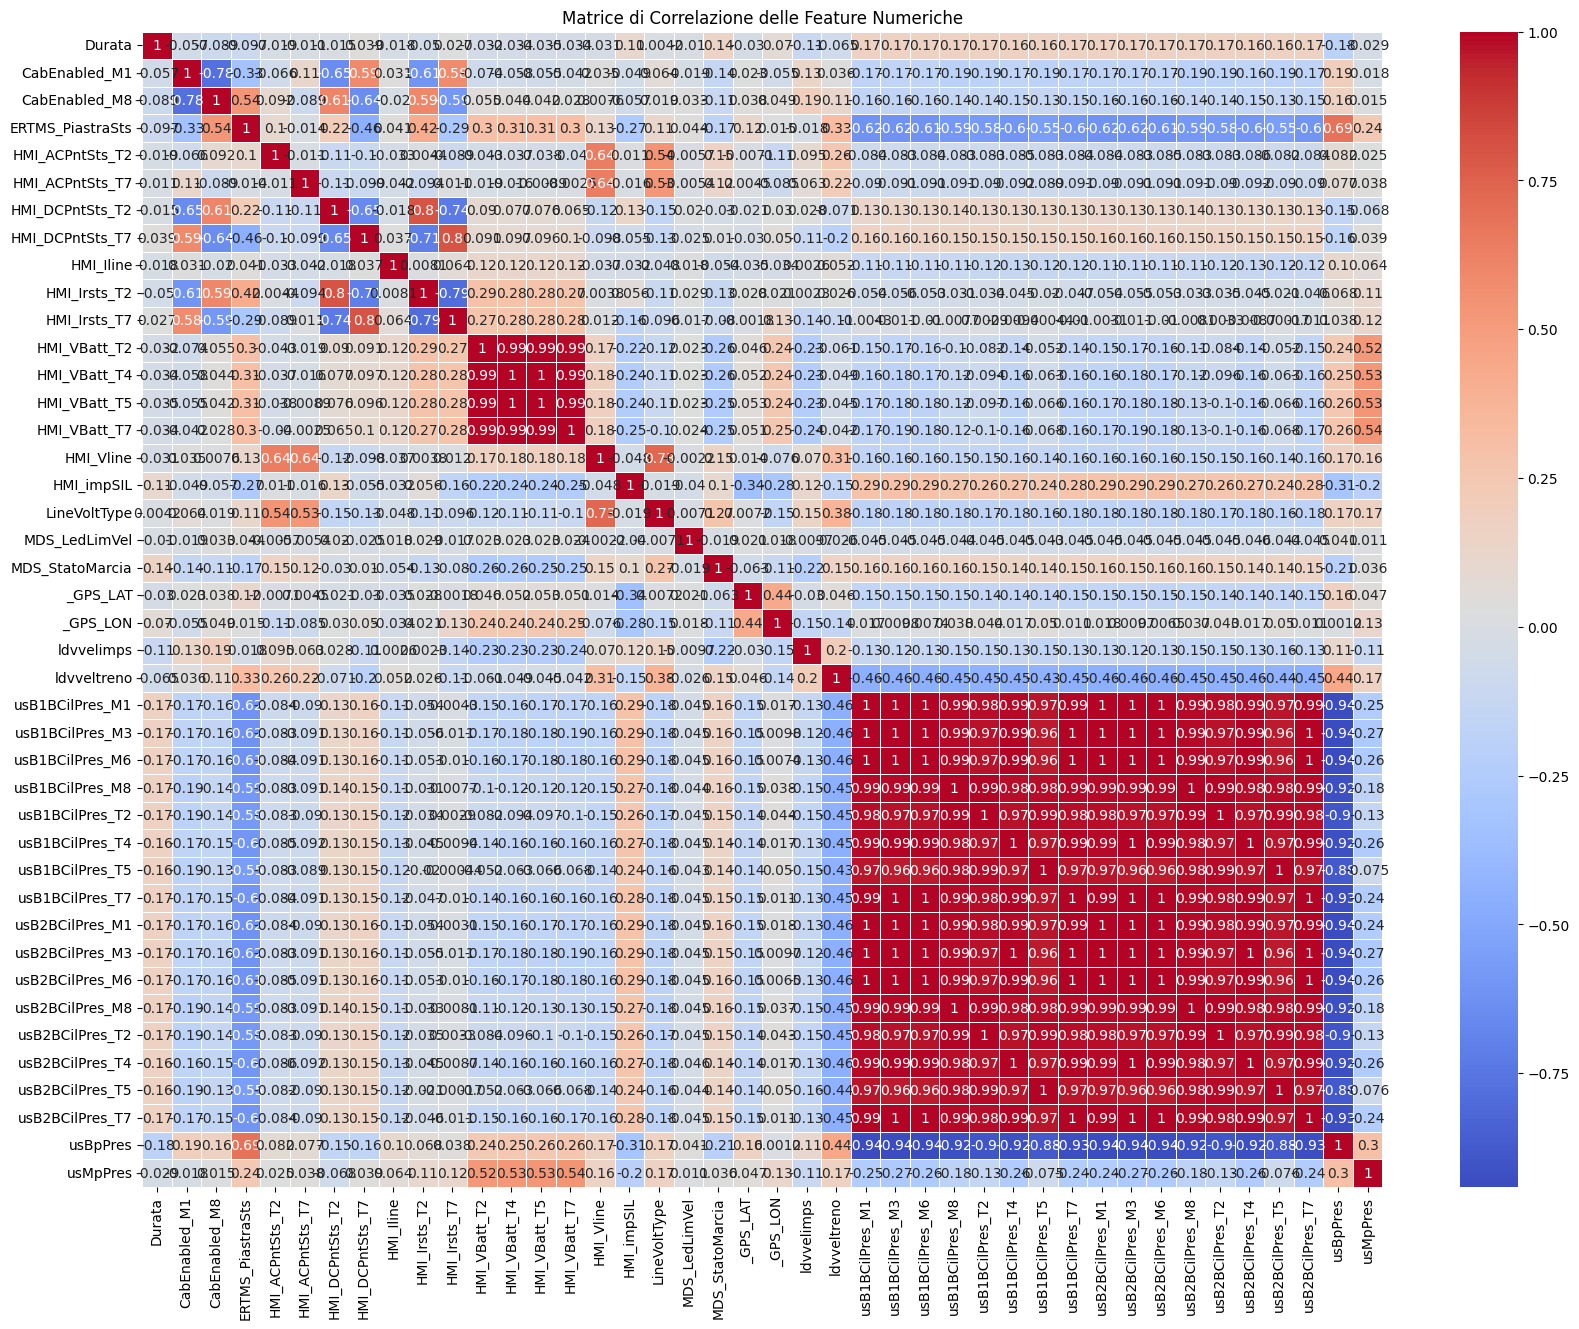

In [12]:
#matrice di correlazione
correlation_matrix = df_vehicle_cleaned[columns_to_generate].corr()

plt.figure(figsize=(20, 15))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Matrice di Correlazione delle Feature Numeriche')
plt.show()

In [13]:
#funzione per plottare la matrice di confusione
def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred, labels=['Anomalia', 'Funzionamento Normale'])
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Anomalia', 'Funzionamento Normale'], 
                yticklabels=['Anomalia', 'Funzionamento Normale'])
    plt.xlabel('Predizione')
    plt.ylabel('Valore Reale')
    plt.title(title)
    plt.show()

Accuratezza del modello: 0.8747
Report di classificazione:
                       precision    recall  f1-score   support

             Anomalia       0.88      0.89      0.89      1569
Funzionamento Normale       0.86      0.86      0.86      1303

             accuracy                           0.87      2872
            macro avg       0.87      0.87      0.87      2872
         weighted avg       0.87      0.87      0.87      2872



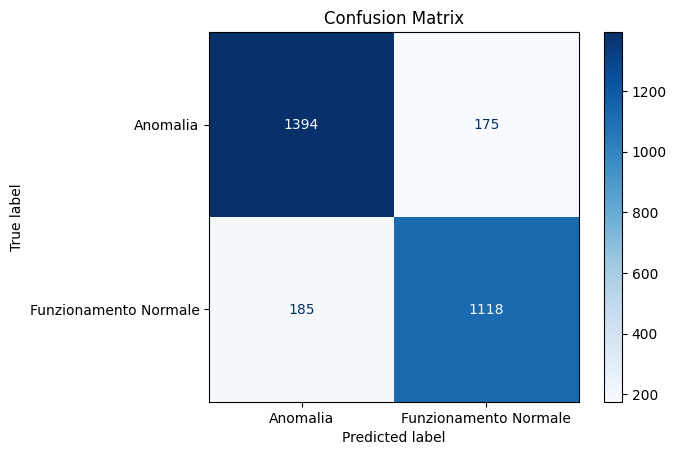

In [14]:
#creatzione modello e valutazione accuratezza
X_final = df_cleaned_no_nan.drop(columns=['Tipo_Evento_Classificato', 'Tipo_Evento', 'Descrizione', 'Timestamp', 'Timestamp chiusura', 'Posizione', 'Flotta', 'Veicolo', 'Codice', 'Nome', 'Test'])

y_final = df_cleaned_no_nan['Tipo_Evento_Classificato']

y_final = y_final.replace({1: 'Funzionamento Normale', 0: 'Anomalia'})

non_numeric_columns = X_final.select_dtypes(include=['object']).columns

X_final = X_final.drop(columns=non_numeric_columns)

X_train, X_test, y_train, y_test = train_test_split(X_final, y_final, test_size=0.2, random_state=42)

rf_model = RandomForestClassifier(random_state=42)

rf_model.fit(X_train, y_train)

y_pred = rf_model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred, target_names=['Anomalia', 'Funzionamento Normale'])

print(f"Accuratezza del modello: {accuracy:.4f}")
print("Report di classificazione:")
print(classification_rep)

conf_matrix = confusion_matrix(y_test, y_pred, labels=['Anomalia', 'Funzionamento Normale'])

disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=['Anomalia', 'Funzionamento Normale'])
disp.plot(cmap=plt.cm.Blues)

plt.title('Confusion Matrix')
plt.show()

In [15]:
#leggo il file csv e pulisco i dati
df_cleaned_no_nan['Timestamp'] = pd.to_datetime(df_cleaned_no_nan['Timestamp'], errors='coerce')

vehicle_data_clean = df_cleaned_no_nan.dropna(subset=['Timestamp', 'Timestamp chiusura'])

vehicle_data_clean = vehicle_data_clean.drop_duplicates(subset=['Descrizione', 'Timestamp'])

print(f"Righe rimaste dopo la pulizia: {len(vehicle_data_clean)}")

Righe rimaste dopo la pulizia: 4010


C:\Users\frogora\AppData\Local\Temp\ipykernel_16440\471781422.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned_no_nan['Timestamp'] = pd.to_datetime(df_cleaned_no_nan['Timestamp'], errors='coerce')


In [16]:
#calcolo il tempo di interarrivo medio tra le anomalie
anomalies = vehicle_data_clean[vehicle_data_clean['Tipo_Evento'] == 'Anomalia']

anomalies_sorted = anomalies.sort_values(by='Timestamp')

anomalies_sorted['Interarrival_Time'] = anomalies_sorted['Timestamp'].diff().dt.total_seconds()

anomalies_interarrival = anomalies_sorted['Interarrival_Time'].dropna()

print(f"Numero di anomalie dopo il calcolo del tempo di interarrivo: {len(anomalies_interarrival)}")

Numero di anomalie dopo il calcolo del tempo di interarrivo: 1811


In [17]:
#filtro le anomalie per la deviazione standard
mean_anomalies = anomalies_interarrival.mean()

std_anomalies = anomalies_interarrival.std()

filtered_anomalies_interarrival = anomalies_interarrival[
    (anomalies_interarrival > mean_anomalies - 2 * std_anomalies) &
    (anomalies_interarrival < mean_anomalies + 2 * std_anomalies)
]

print(f"Numero di anomalie dopo il filtraggio: {len(filtered_anomalies_interarrival)}")

Numero di anomalie dopo il filtraggio: 1790


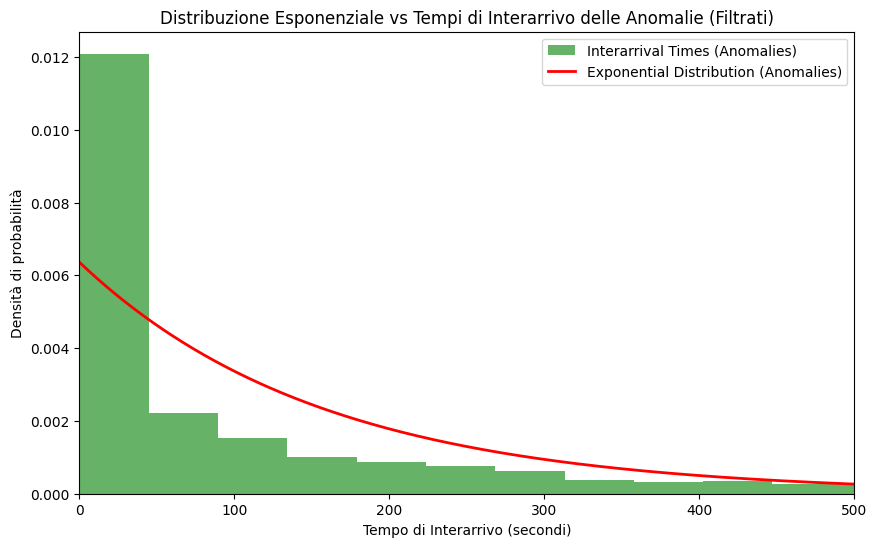

In [18]:
#distribuzione esponenziale sui tempi di interarrivo delle anomalie, filtrato per deviazione standard maggiore di 2
lambda_expon_anomalies = 1 / filtered_anomalies_interarrival.mean()
x_limit = 500
expon_distribution_anomalies = expon.pdf(range(x_limit), scale=1/lambda_expon_anomalies)

plt.figure(figsize=(10,6))
plt.hist(filtered_anomalies_interarrival, bins=100, density=True, alpha=0.6, color='g', label='Interarrival Times (Anomalies)')
plt.plot(range(x_limit), expon_distribution_anomalies, 'r-', lw=2, label='Exponential Distribution (Anomalies)')
plt.title('Distribuzione Esponenziale vs Tempi di Interarrivo delle Anomalie (Filtrati)')
plt.xlabel('Tempo di Interarrivo (secondi)')
plt.ylabel('Densità di probabilità')
plt.xlim(0, x_limit)
plt.legend()
plt.show()

In [19]:
#calcolo il tempo di interarrivo medio tra i funzionamenti normali
normal_operations = vehicle_data_clean[vehicle_data_clean['Tipo_Evento'] == 'Funzionamento Normale']

normal_operations_sorted = normal_operations.sort_values(by='Timestamp')

normal_operations_sorted['Interarrival_Time'] = normal_operations_sorted['Timestamp'].diff().dt.total_seconds()

normal_interarrival = normal_operations_sorted['Interarrival_Time'].dropna()

print(f"Numero di operazioni normali dopo il calcolo del tempo di interarrivo: {len(normal_interarrival)}")

Numero di operazioni normali dopo il calcolo del tempo di interarrivo: 2197


In [20]:
#filtro i log di funzionamento nornmale per la deviazione standard
mean_normal = normal_interarrival.mean()

std_normal = normal_interarrival.std()

filtered_normal_interarrival = normal_interarrival[
    (normal_interarrival > mean_normal - 2 * std_normal) &
    (normal_interarrival < mean_normal + 2 * std_normal)
]

print(f"Numero di operazioni normali dopo il filtraggio: {len(filtered_normal_interarrival)}")

Numero di operazioni normali dopo il filtraggio: 2172


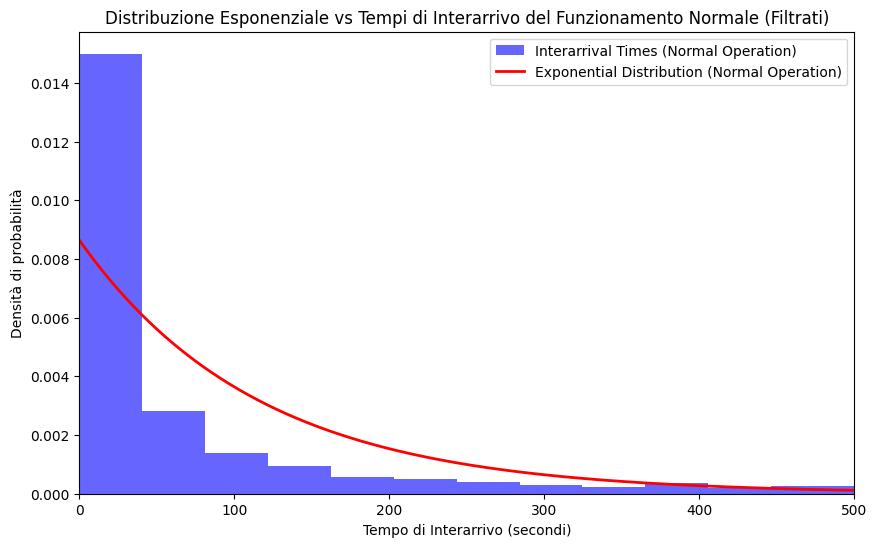

In [21]:
#distribuzione esponenziale sui tempi di interarrivo del funzionamento normale, filtrato per deviazione standard maggiore di 2
lambda_expon_normal = 1 / filtered_normal_interarrival.mean()
expon_distribution_normal = expon.pdf(range(x_limit), scale=1/lambda_expon_normal)

plt.figure(figsize=(10,6))
plt.hist(filtered_normal_interarrival, bins=100, density=True, alpha=0.6, color='b', label='Interarrival Times (Normal Operation)')
plt.plot(range(x_limit), expon_distribution_normal, 'r-', lw=2, label='Exponential Distribution (Normal Operation)')
plt.title('Distribuzione Esponenziale vs Tempi di Interarrivo del Funzionamento Normale (Filtrati)')
plt.xlabel('Tempo di Interarrivo (secondi)')
plt.ylabel('Densità di probabilità')
plt.xlim(0, x_limit)
plt.legend()
plt.show()

In [22]:
#calcolo media e mediana dei tempi di interarrivo delle anomalie e del funzionamento normale
mean_filtered_anomalies = filtered_anomalies_interarrival.mean()
median_filtered_anomalies = filtered_anomalies_interarrival.median()
print(f"Media dei tempi di interarrivo delle anomalie filtrate: {mean_filtered_anomalies}")
print(f"Mediana dei tempi di interarrivo delle anomalie filtrate: {median_filtered_anomalies}")

mean_filtered_normal = filtered_normal_interarrival.mean()
median_filtered_normal = filtered_normal_interarrival.median()
print(f"Media dei tempi di interarrivo del funzionamento normale filtrato: {mean_filtered_normal}")
print(f"Mediana dei tempi di interarrivo del funzionamento normale filtrato: {median_filtered_normal}")

Media dei tempi di interarrivo delle anomalie filtrate: 157.1141134078212
Mediana dei tempi di interarrivo delle anomalie filtrate: 30.200499999999998
Media dei tempi di interarrivo del funzionamento normale filtrato: 115.65564917127072
Mediana dei tempi di interarrivo del funzionamento normale filtrato: 22.298499999999997


In [23]:
#caricare il dataset e selezionare i dati
print(f"Dataset caricato con {len(df_cleaned_no_nan)} righe.")

df_anomalie = df_cleaned_no_nan[df_cleaned_no_nan['Tipo_Evento_Classificato'] == 0]
df_normali = df_cleaned_no_nan[df_cleaned_no_nan['Tipo_Evento_Classificato'] == 1]
print(f"Eventi di anomalia selezionati: {len(df_anomalie)} righe.")
print(f"Eventi di funzionamento normale selezionati: {len(df_normali)} righe.")

Dataset caricato con 14356 righe.
Eventi di anomalia selezionati: 7766 righe.
Eventi di funzionamento normale selezionati: 6590 righe.


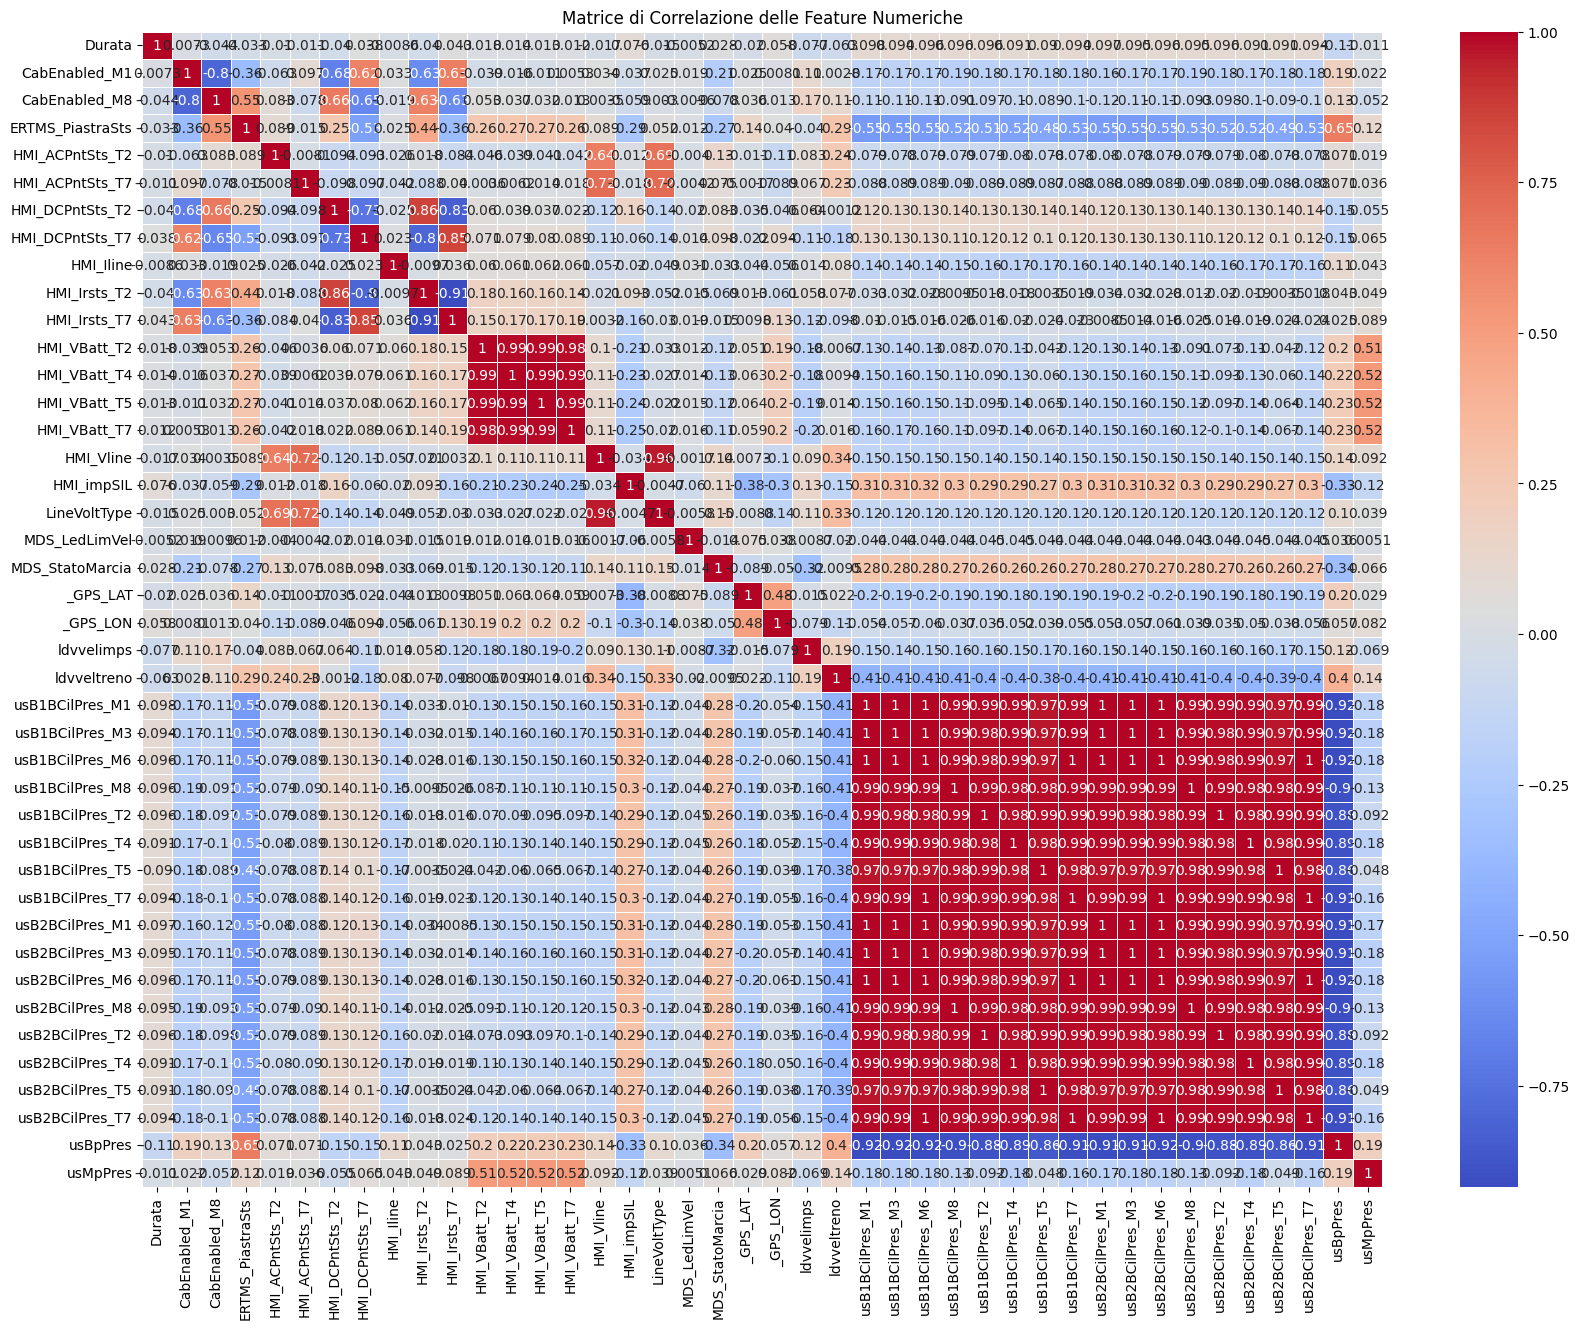

In [24]:
#matrice di correlazione
correlation_matrix = df_anomalie[columns_to_generate].corr()

plt.figure(figsize=(20, 15))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Matrice di Correlazione delle Feature Numeriche')
plt.show()

In [25]:
#creatzione modello e valutazione accuratezza
X_final = df_cleaned_no_nan.drop(columns=['Tipo_Evento_Classificato', 'Tipo_Evento', 'Descrizione', 'Timestamp', 'Timestamp chiusura', 'Posizione', 'Flotta', 'Veicolo', 'Codice', 'Nome', 'Test', 'Longitudine', 'Latitudine', 'Contemporaneo'])

y_final = df_cleaned_no_nan['Tipo_Evento_Classificato']

y_final = y_final.replace({1: 'Funzionamento Normale', 0: 'Anomalia'})

non_numeric_columns = X_final.select_dtypes(include=['object']).columns

X_final = X_final.drop(columns=non_numeric_columns)

X_train, X_test, y_train, y_test = train_test_split(X_final, y_final, test_size=0.2, random_state=42)

rf_model = RandomForestClassifier(random_state=42)

rf_model.fit(X_train, y_train)

y_pred = rf_model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred, target_names=['Anomalia', 'Funzionamento Normale'])

print(f"Accuratezza del modello: {accuracy:.4f}")
print("Report di classificazione:")
print(classification_rep)

Accuratezza del modello: 0.8653
Report di classificazione:
                       precision    recall  f1-score   support

             Anomalia       0.87      0.88      0.88      1569
Funzionamento Normale       0.86      0.84      0.85      1303

             accuracy                           0.87      2872
            macro avg       0.86      0.86      0.86      2872
         weighted avg       0.87      0.87      0.87      2872



In [26]:
#rimuovo i duplicati consecutivi
columns_to_check = ['Descrizione', 'Timestamp', 'Codice', 'Nome']

df_deduplicated_anomalies = df_anomalie.loc[(df_anomalie[columns_to_check] != df_anomalie[columns_to_check].shift()).any(axis=1)]

print(f"Righe originali: {len(df_anomalie)}")
print(f"Righe dopo rimozione delle ridondanze: {len(df_deduplicated_anomalies)}")


Righe originali: 7766
Righe dopo rimozione delle ridondanze: 1828


In [27]:
#rimuovo i duplicati consecutivi
columns_to_check = ['Descrizione', 'Timestamp', 'Codice', 'Nome']

df_deduplicated_normals = df_normali.loc[(df_normali[columns_to_check] != df_normali[columns_to_check].shift()).any(axis=1)]

print(f"Righe originali: {len(df_normali)}")
print(f"Righe dopo rimozione delle ridondanze: {len(df_deduplicated_normals)}")


Righe originali: 6590
Righe dopo rimozione delle ridondanze: 2198


In [28]:
#generazione dati sintetici con copula gaussiana
warnings.filterwarnings("ignore", category=RuntimeWarning)

data_us_anomalie = df_deduplicated_anomalies[columns_to_generate].drop(columns=['Durata'])
data_us_normali = df_deduplicated_normals[columns_to_generate].drop(columns=['Durata'])

copula_us_anomalie = GaussianMultivariate()
copula_us_anomalie.fit(data_us_anomalie)

copula_us_normali = GaussianMultivariate()
copula_us_normali.fit(data_us_normali)

synthetic_us_anomalie = copula_us_anomalie.sample(len(data_us_anomalie))
synthetic_us_normali = copula_us_normali.sample(len(data_us_normali))

alpha = 0.2
beta = 1.9

media_durata_anomalie = 157 * alpha
media_durata_normali = 115 * alpha

sigma_anomalie = 1 * beta
sigma_normali = 1 * beta

synthetic_us_anomalie['Durata'] = np.random.lognormal(mean=np.log(media_durata_anomalie), sigma=sigma_anomalie, size=len(synthetic_us_anomalie))
synthetic_us_normali['Durata'] = np.random.lognormal(mean=np.log(media_durata_normali), sigma=sigma_normali, size=len(synthetic_us_normali))

synthetic_us_anomalie['Tipo_Evento'] = "Anomalia"
synthetic_us_normali['Tipo_Evento'] = "Funzionamento Normale"

synthetic_us_anomalie['Tipo_Evento_Classificato'] = 0
synthetic_us_normali['Tipo_Evento_Classificato'] = 1

warnings.filterwarnings("default", category=RuntimeWarning)

In [29]:
#sposto colonna durata in prima posizione e salvo i dataset
col_durata_anomalie = synthetic_us_anomalie.pop('Durata')
synthetic_us_anomalie.insert(0, 'Durata', col_durata_anomalie)

col_durata_normali = synthetic_us_normali.pop('Durata')
synthetic_us_normali.insert(0, 'Durata', col_durata_normali)

synthetic_us_anomalie.to_csv('dataset_sintetico_anomalie.csv', index=False)
synthetic_us_normali.to_csv('dataset_sintetico_normali.csv', index=False)

In [30]:
#calcolo media e mediana dei tempi di interarrivo delle anomalie e del funzionamento normale
mean_filtered_synthetic_anomalies = synthetic_us_anomalie['Durata'].mean()
median_filtered_synthetic_anomalies = synthetic_us_anomalie['Durata'].median()
print(f"Media dei tempi di interarrivo delle anomalie filtrate: {mean_filtered_synthetic_anomalies}")
print(f"Mediana dei tempi di interarrivo delle anomalie filtrate: {median_filtered_synthetic_anomalies}")

mean_filtered_synthetic_normal = synthetic_us_normali['Durata'].mean()
median_filtered_synthetic_normal = synthetic_us_normali['Durata'].median()
print(f"Media dei tempi di interarrivo del funzionamento normale filtrato: {mean_filtered_synthetic_normal}")
print(f"Mediana dei tempi di interarrivo del funzionamento normale filtrato: {median_filtered_synthetic_normal}")

Media dei tempi di interarrivo delle anomalie filtrate: 193.3323759937634
Mediana dei tempi di interarrivo delle anomalie filtrate: 33.486727468352925
Media dei tempi di interarrivo del funzionamento normale filtrato: 123.97434237229005
Mediana dei tempi di interarrivo del funzionamento normale filtrato: 21.105620182085307


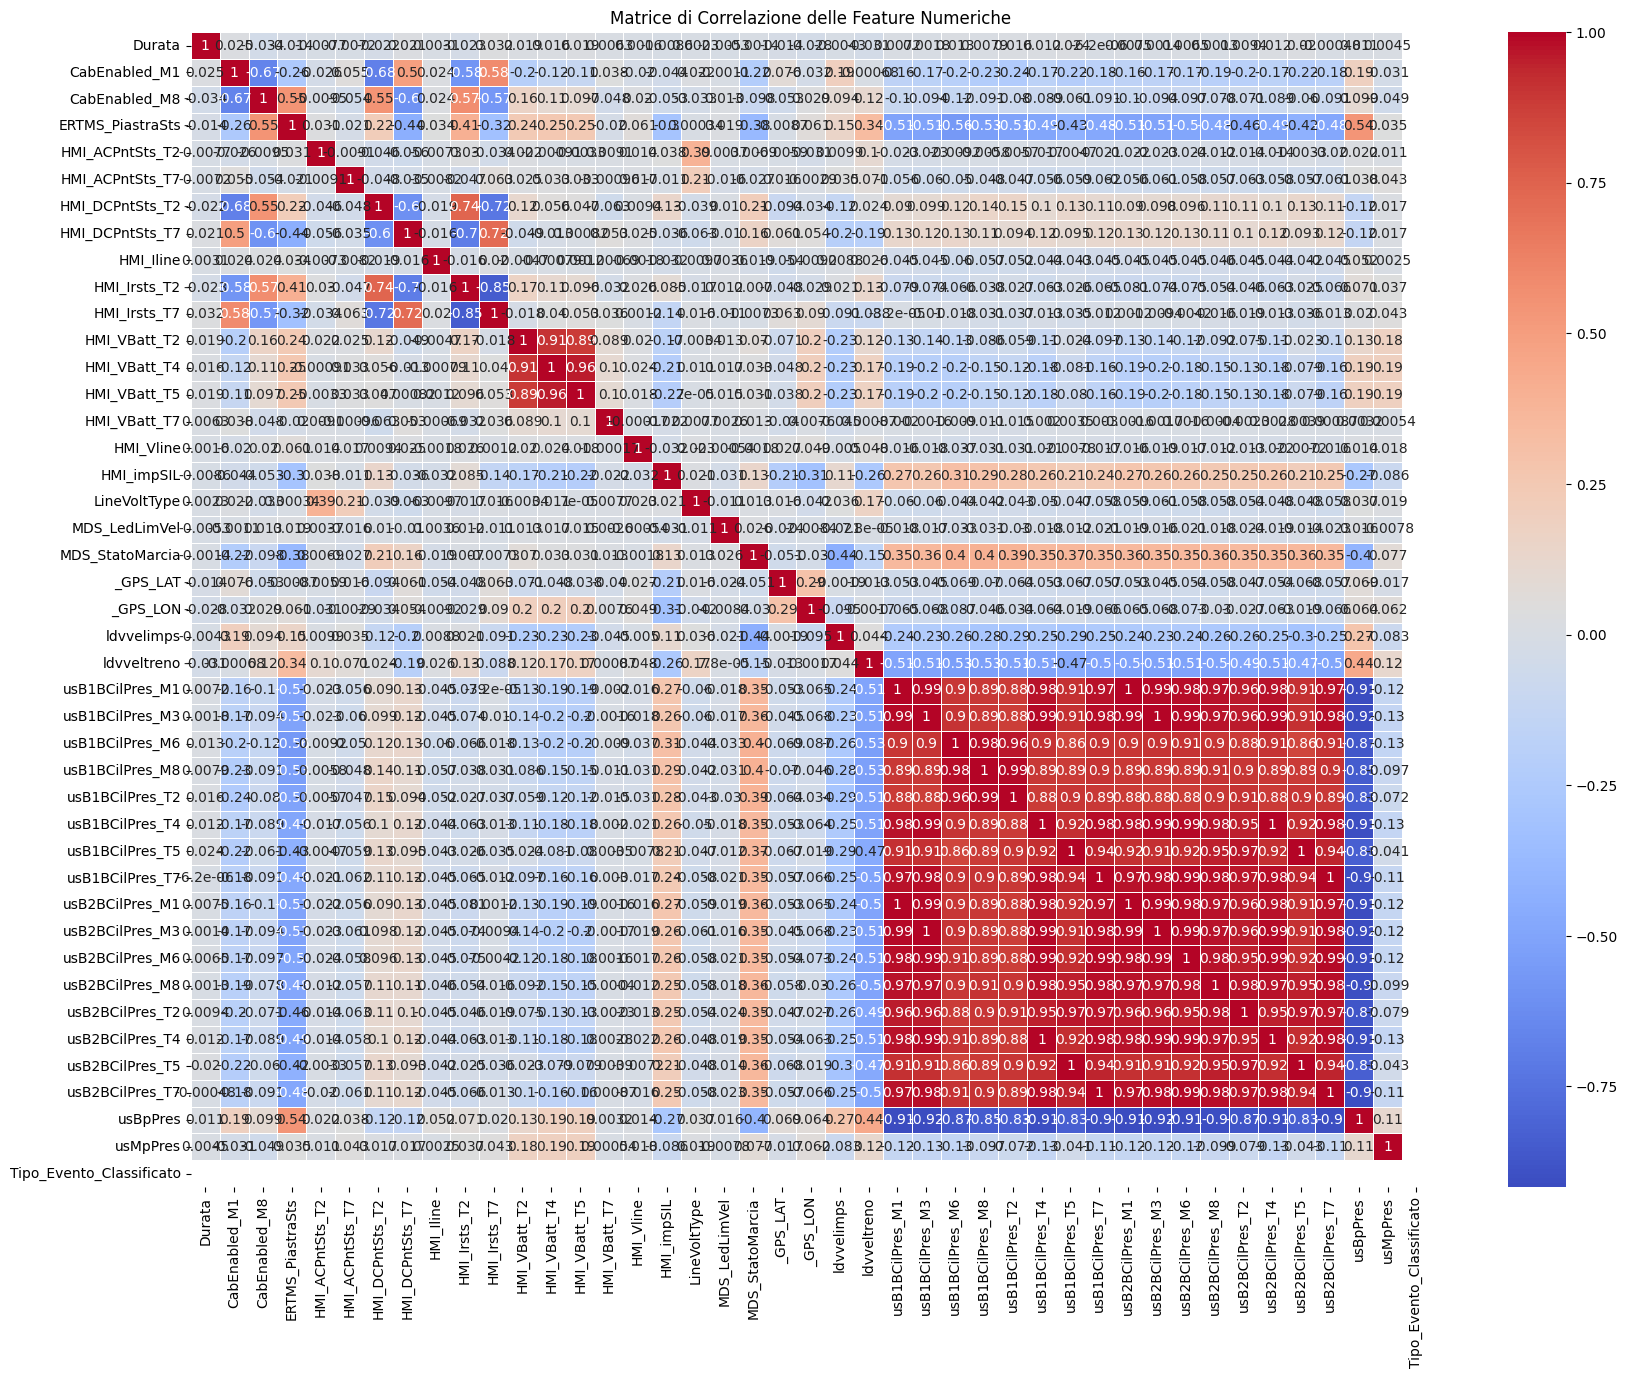

In [31]:
#matrice di correlazione dei dati sintetici con copula gaussiana
numerical_columns = synthetic_us_anomalie.select_dtypes(include=['float64', 'int64']).columns

correlation_matrix = synthetic_us_anomalie[numerical_columns].corr()

plt.figure(figsize=(20, 15))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Matrice di Correlazione delle Feature Numeriche')
plt.show()

In [ ]:
#matrice di #matrice di correlazione dei dati sintetici con copula gaussiana
numerical_columns = synthetic_us_normali.select_dtypes(include=['float64', 'int64']).columns

correlation_matrix = synthetic_us_normali[numerical_columns].corr()

plt.figure(figsize=(20, 15))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Matrice di Correlazione delle Feature Numeriche')
plt.show()

NameError: name 'synthetic_us_normali' is not defined

In [33]:
#funzione per plottare la matrice di confusione
def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred, labels=['Anomalia', 'Funzionamento Normale'])
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Anomalia', 'Funzionamento Normale'], 
                yticklabels=['Anomalia', 'Funzionamento Normale'])
    plt.xlabel('Predizione')
    plt.ylabel('Valore Reale')
    plt.title(title)
    plt.show()

Accuratezza del modello sui dati sintetici (anomalie): 0.7046
Report di classificazione sui dati sintetici (anomalie):
                       precision    recall  f1-score   support

             Anomalia       1.00      0.70      0.83      1828
Funzionamento Normale       0.00      1.00      0.00         0

             accuracy                           0.70      1828
            macro avg       0.50      0.85      0.41      1828
         weighted avg       1.00      0.70      0.83      1828



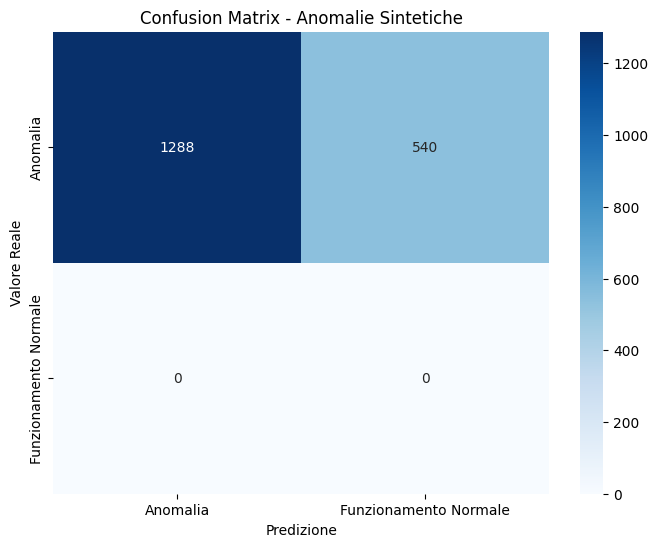

In [34]:
#testiamo il modello sulle anomalie sintetiche
X_sintetici_anomalie = synthetic_us_anomalie.drop(columns=[
    'Tipo_Evento_Classificato','Timestamp', 'Timestamp chiusura'], errors='ignore')

non_numeric_columns_sintetici_anomalie = X_sintetici_anomalie.select_dtypes(include=['object']).columns
X_sintetici_anomalie = X_sintetici_anomalie.drop(columns=non_numeric_columns_sintetici_anomalie)

y_sintetici_true_anomalie = ['Anomalia'] * len(X_sintetici_anomalie)
y_pred_sintetici_anomalie = rf_model.predict(X_sintetici_anomalie)

accuracy_sintetici_anomalie = accuracy_score(y_sintetici_true_anomalie, y_pred_sintetici_anomalie)
classification_rep_sintetici_anomalie = classification_report(y_sintetici_true_anomalie, y_pred_sintetici_anomalie, 
                                                              target_names=['Anomalia', 'Funzionamento Normale'], 
                                                              zero_division=1)

print(f"Accuratezza del modello sui dati sintetici (anomalie): {accuracy_sintetici_anomalie:.4f}")
print("Report di classificazione sui dati sintetici (anomalie):")
print(classification_rep_sintetici_anomalie)

plot_confusion_matrix(y_sintetici_true_anomalie, y_pred_sintetici_anomalie, 'Confusion Matrix - Anomalie Sintetiche')


Accuratezza del modello sui dati sintetici (funzionamenti normali): 0.6101
Report di classificazione sui dati sintetici (funzionamenti normali):
                       precision    recall  f1-score   support

             Anomalia       0.00      1.00      0.00         0
Funzionamento Normale       1.00      0.61      0.76      2198

             accuracy                           0.61      2198
            macro avg       0.50      0.81      0.38      2198
         weighted avg       1.00      0.61      0.76      2198



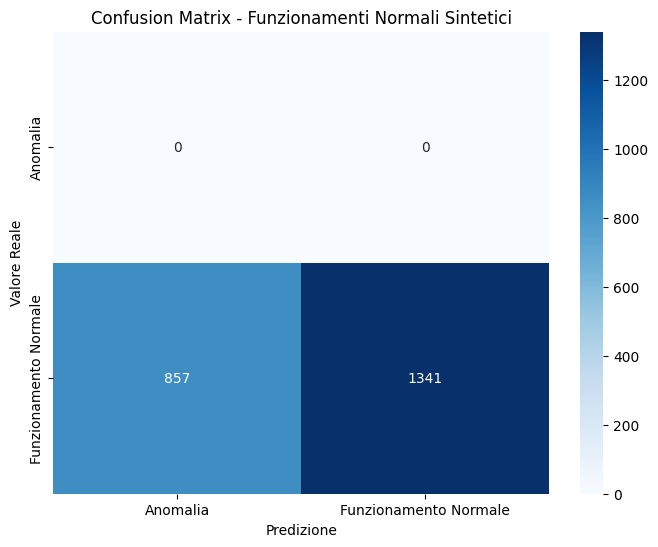

In [35]:
#testiamo il modello sui funzionamenti normali sintetiche
X_sintetici_normali = synthetic_us_normali.drop(columns=[
    'Tipo_Evento_Classificato', 'Timestamp', 'Timestamp chiusura'], errors='ignore')

non_numeric_columns_sintetici_normali = X_sintetici_normali.select_dtypes(include=['object']).columns
X_sintetici_normali = X_sintetici_normali.drop(columns=non_numeric_columns_sintetici_normali)

y_sintetici_true_normali = ['Funzionamento Normale'] * len(X_sintetici_normali)
y_pred_sintetici_normali = rf_model.predict(X_sintetici_normali)

accuracy_sintetici_normali = accuracy_score(y_sintetici_true_normali, y_pred_sintetici_normali)
classification_rep_sintetici_normali = classification_report(y_sintetici_true_normali, y_pred_sintetici_normali, 
                                                             target_names=['Anomalia', 'Funzionamento Normale'], 
                                                             zero_division=1)

print(f"Accuratezza del modello sui dati sintetici (funzionamenti normali): {accuracy_sintetici_normali:.4f}")
print("Report di classificazione sui dati sintetici (funzionamenti normali):")
print(classification_rep_sintetici_normali)

plot_confusion_matrix(y_sintetici_true_normali, y_pred_sintetici_normali, 'Confusion Matrix - Funzionamenti Normali Sintetici')

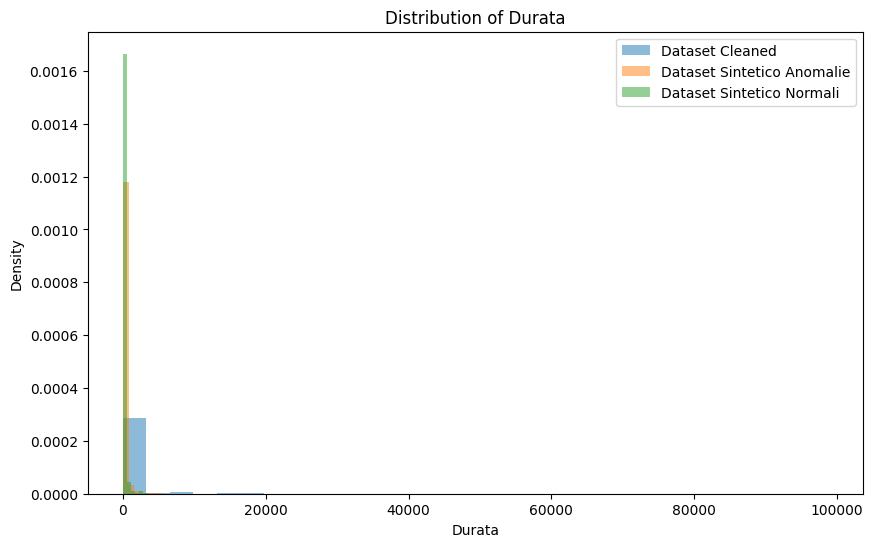

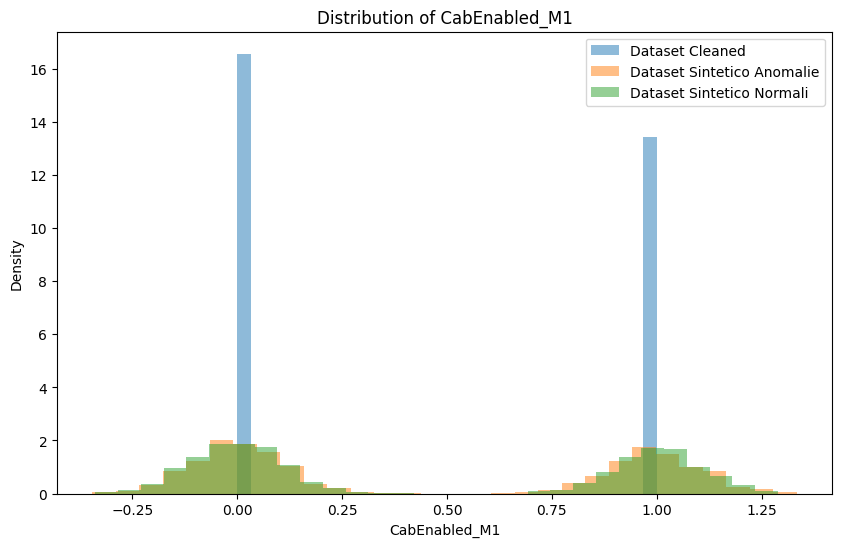

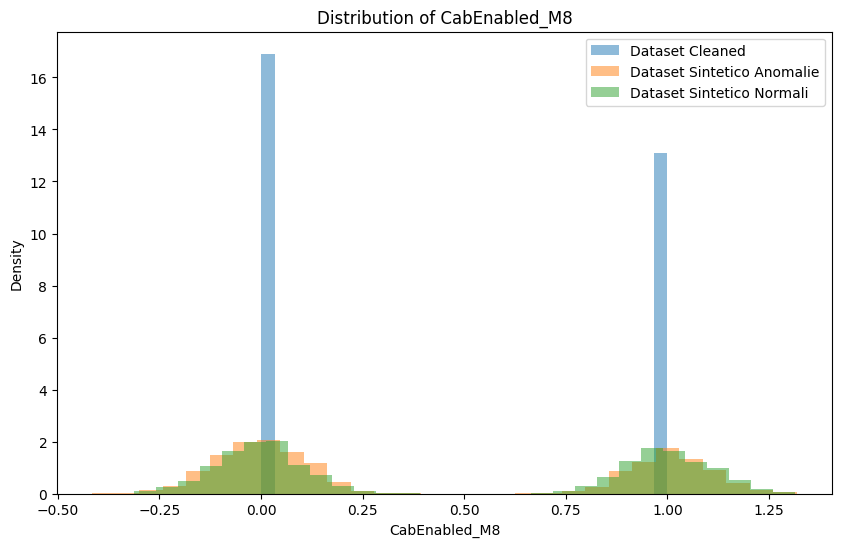

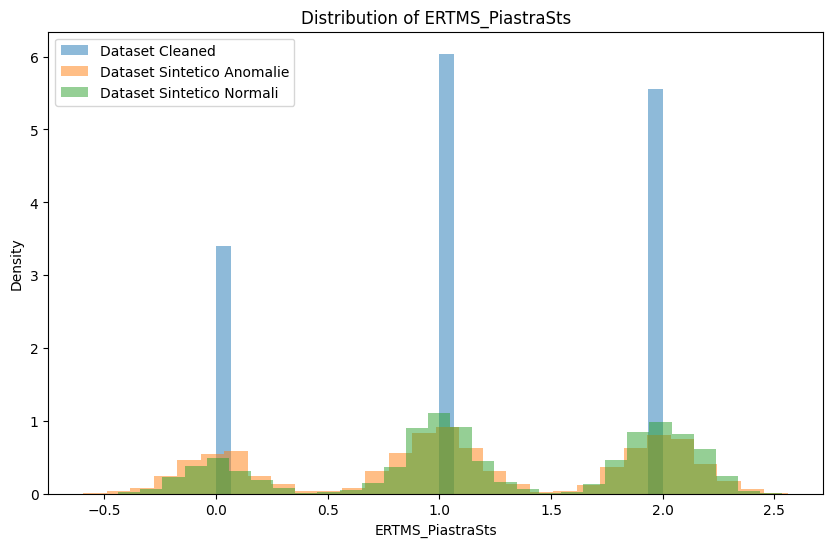

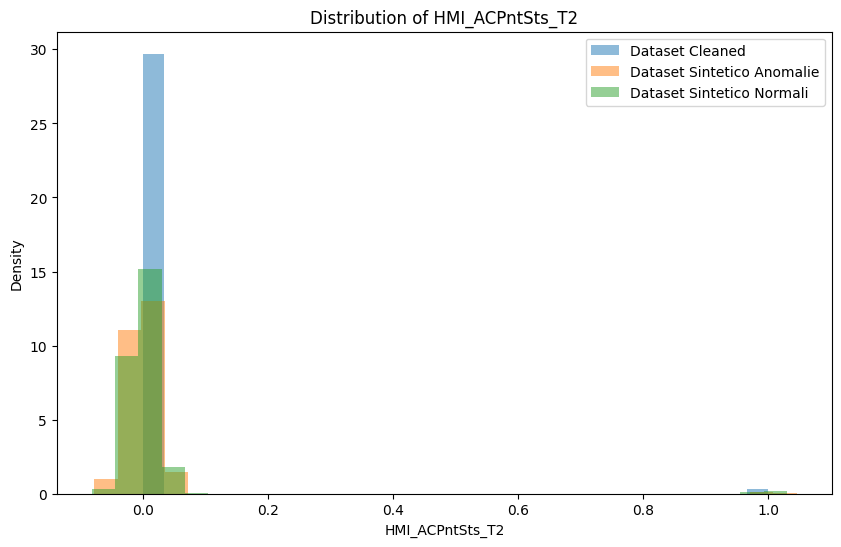

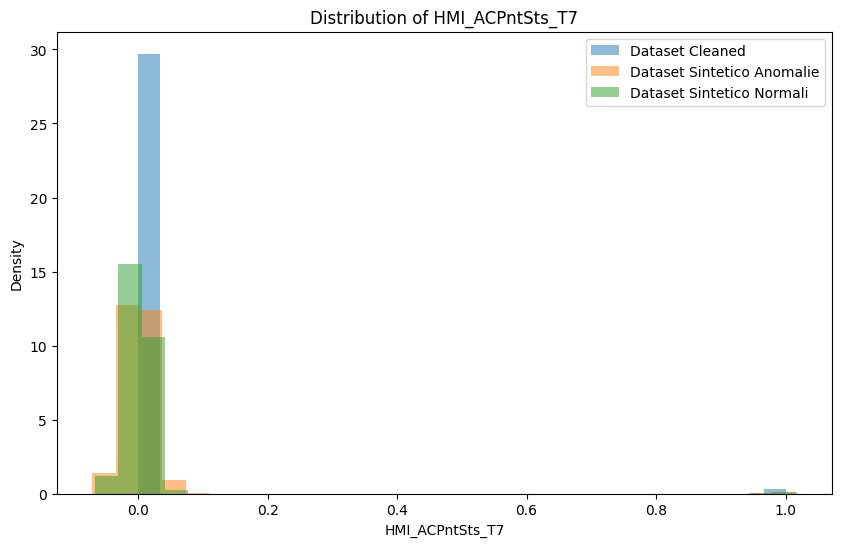

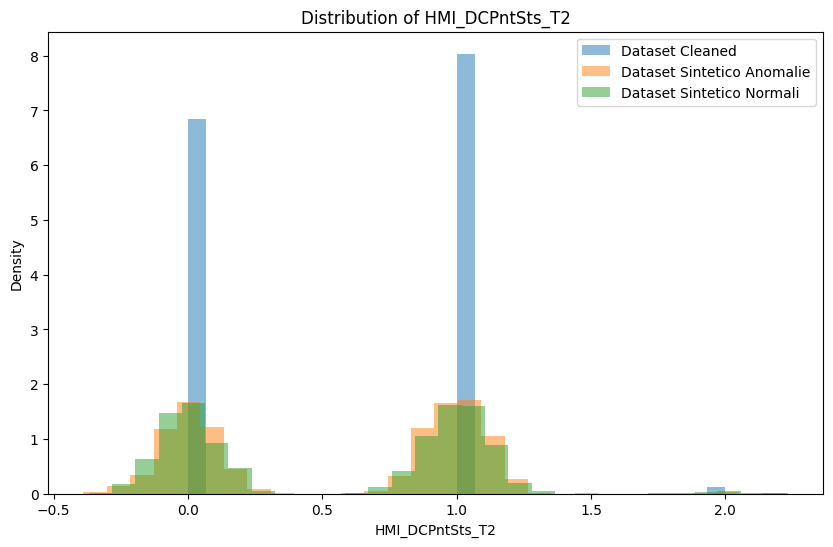

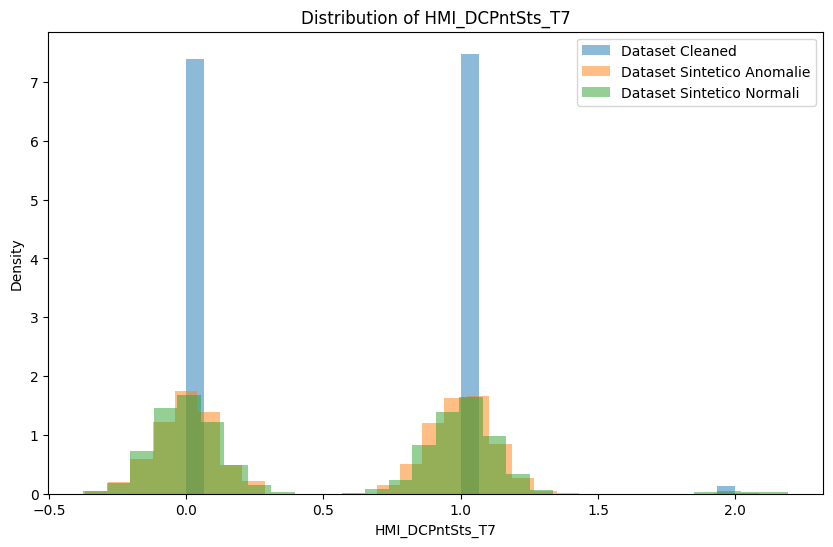

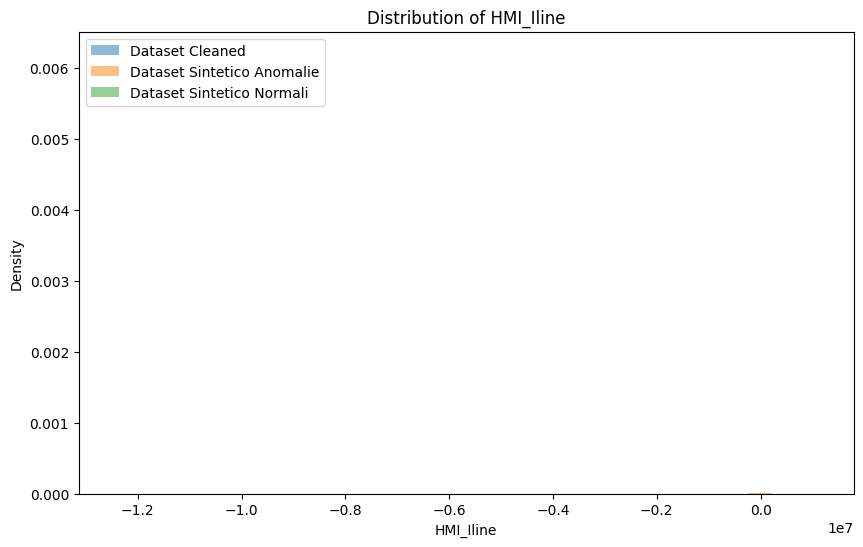

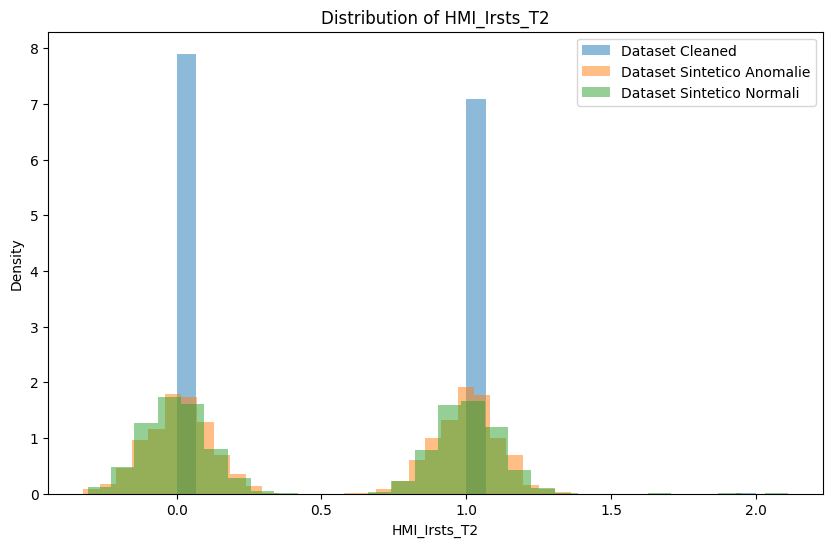

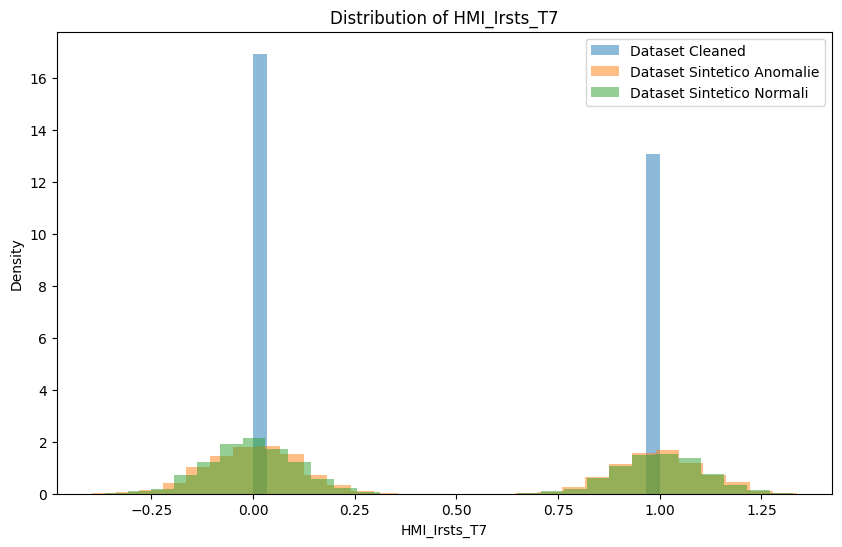

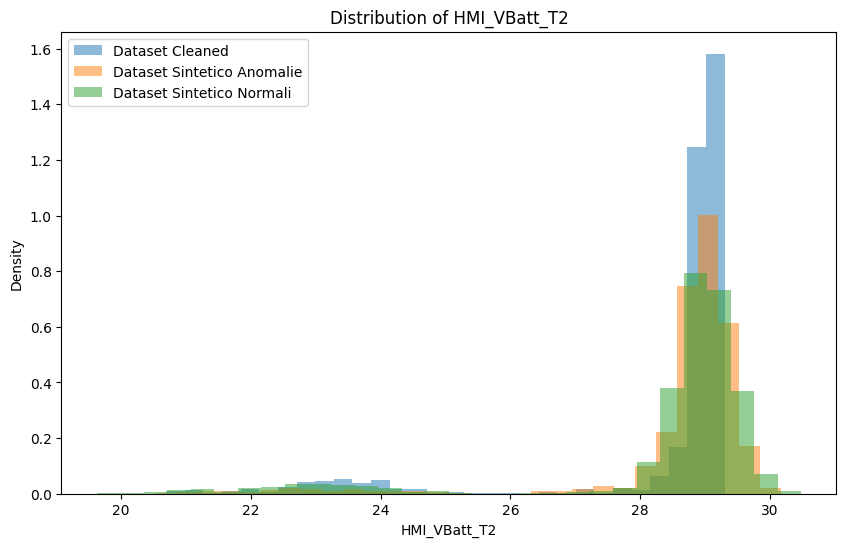

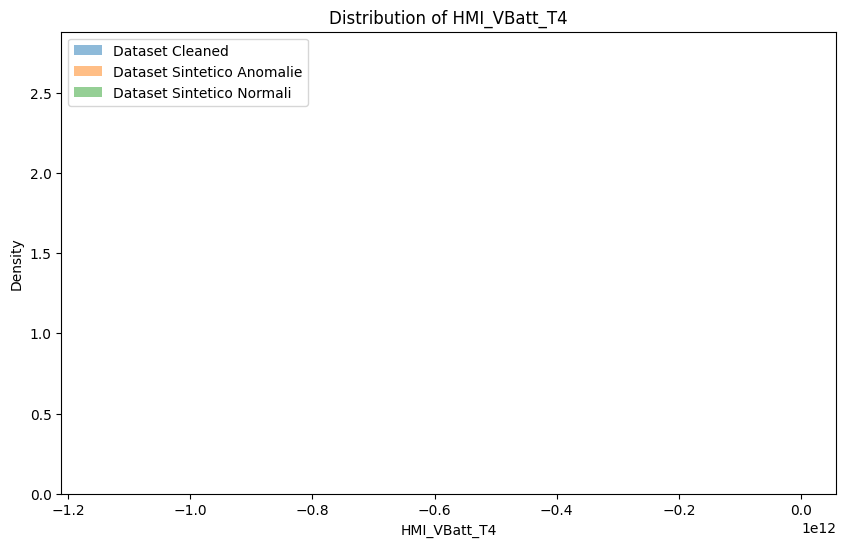

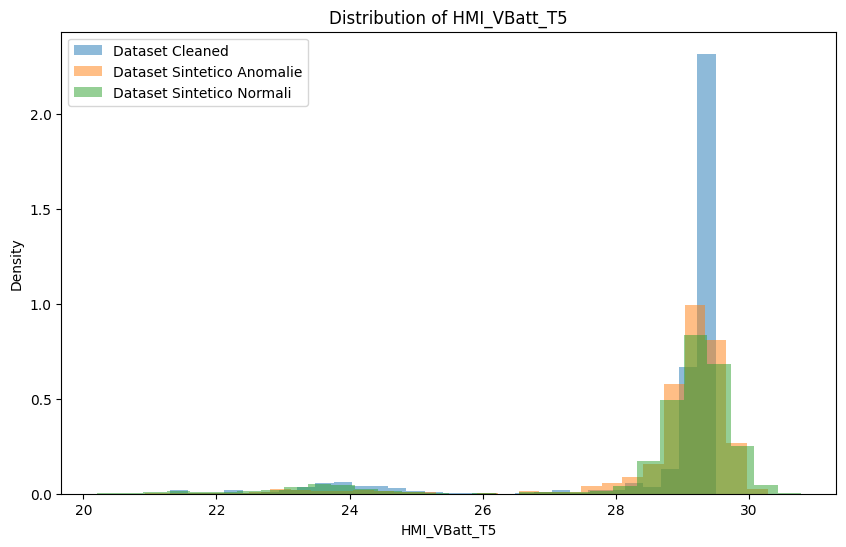

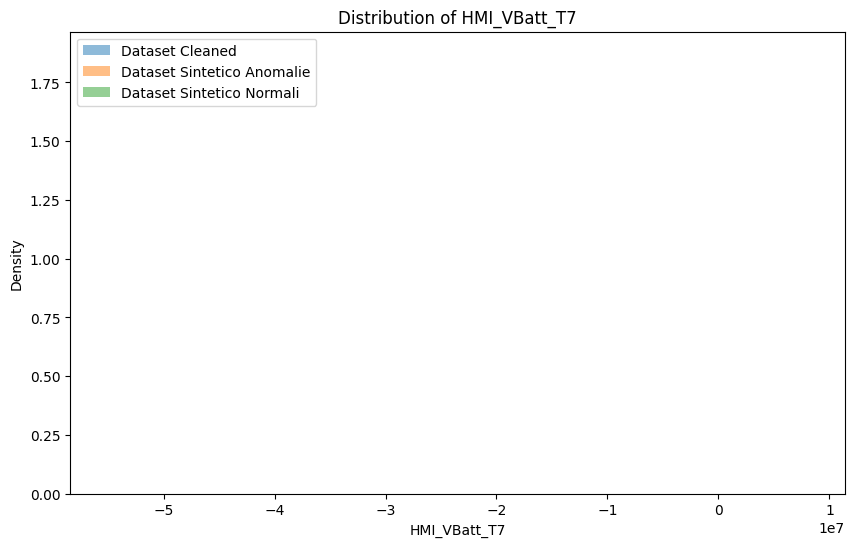

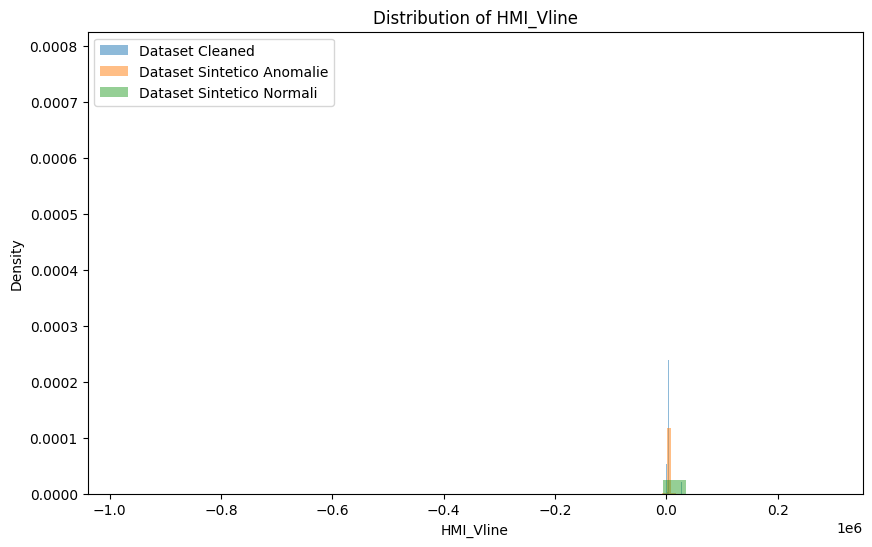

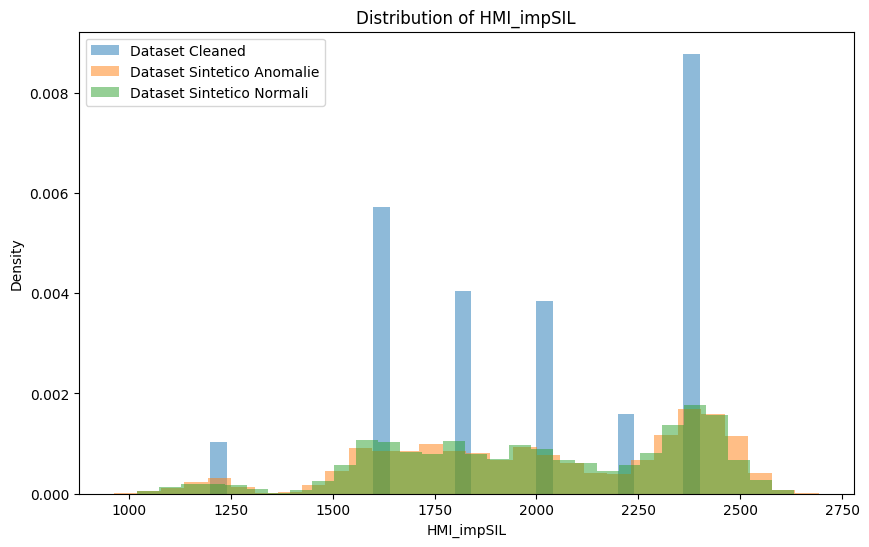

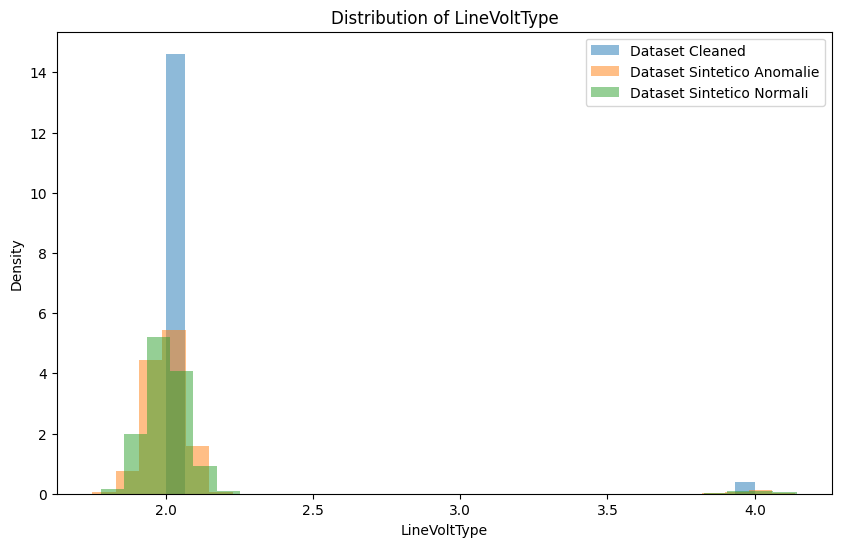

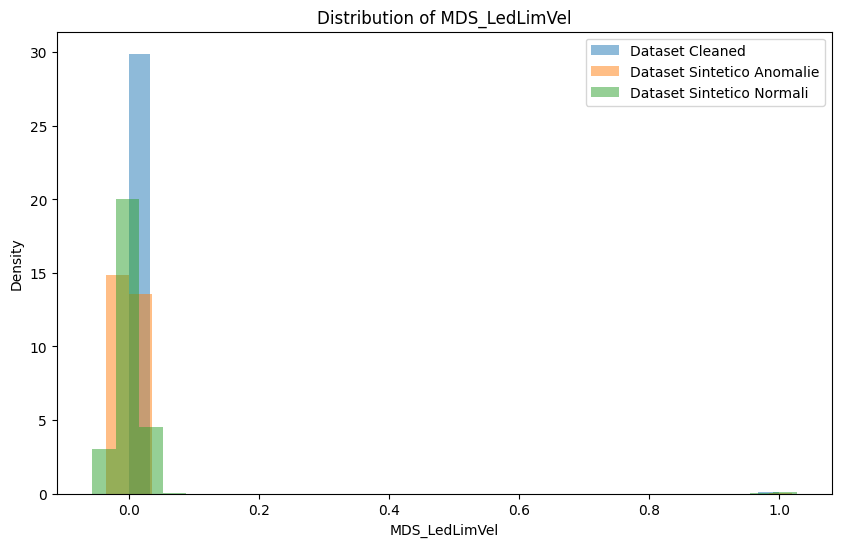

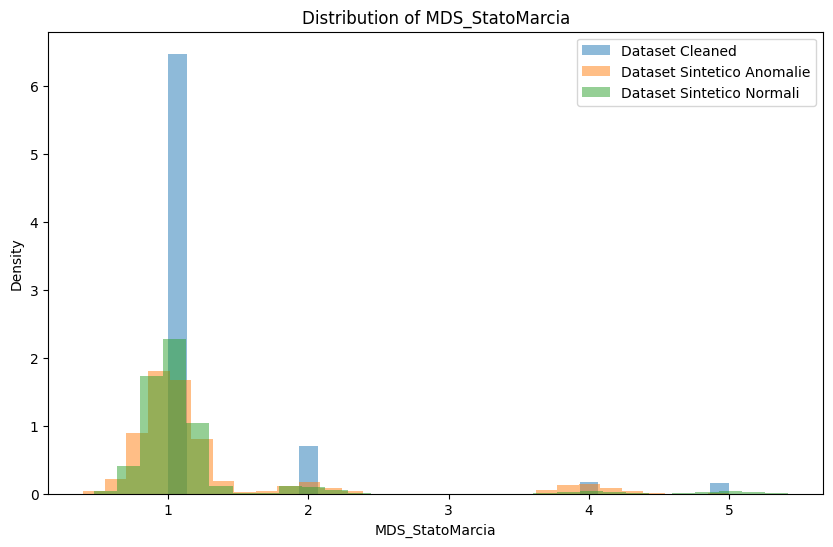

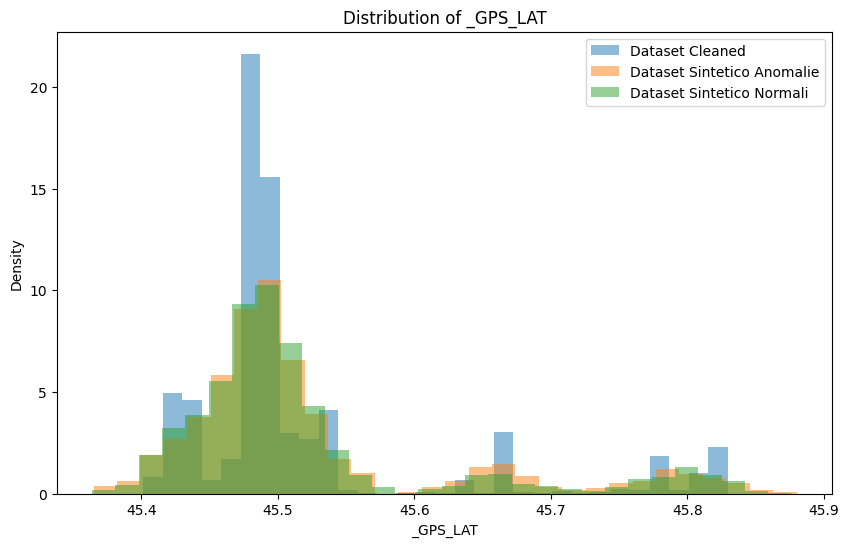

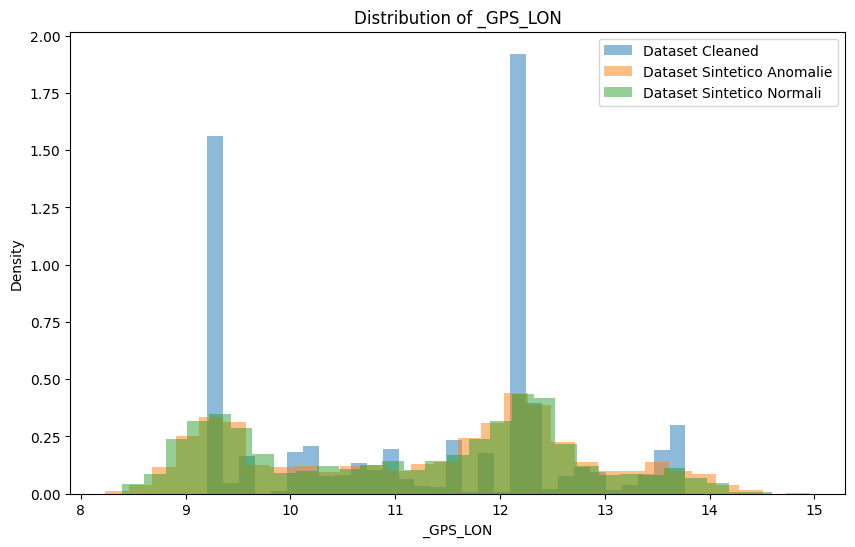

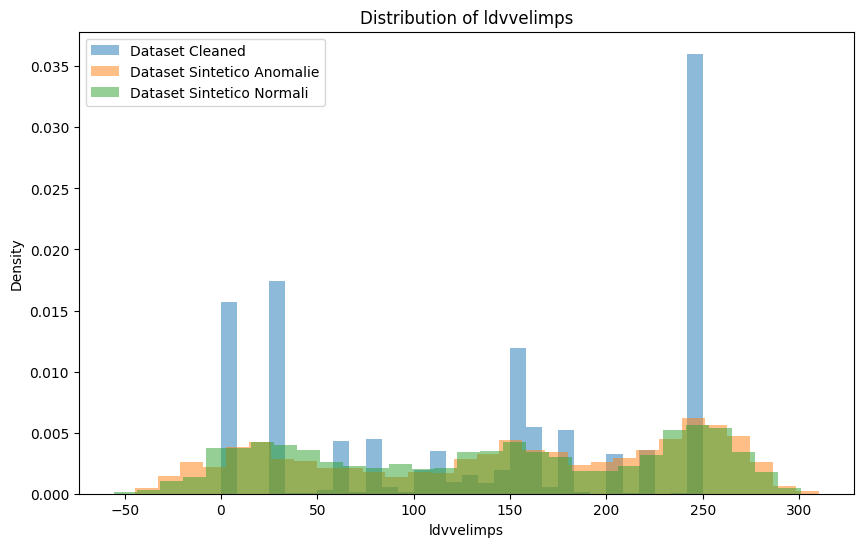

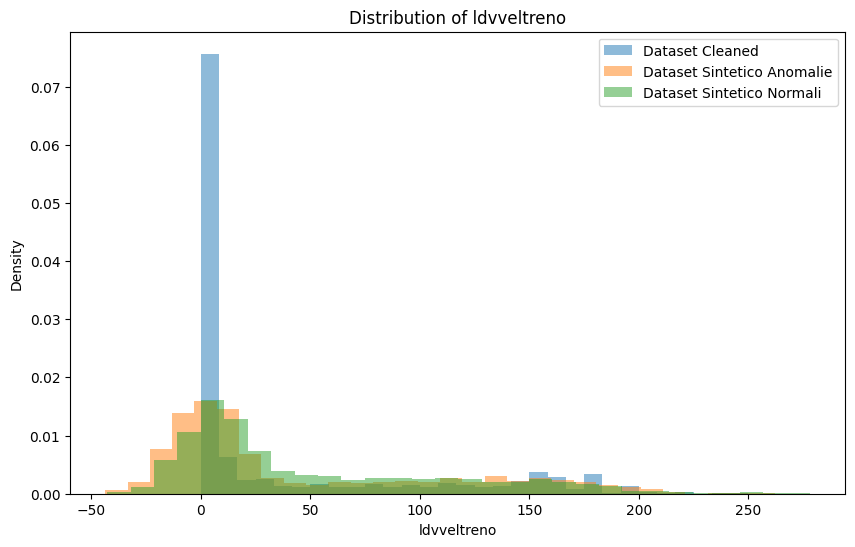

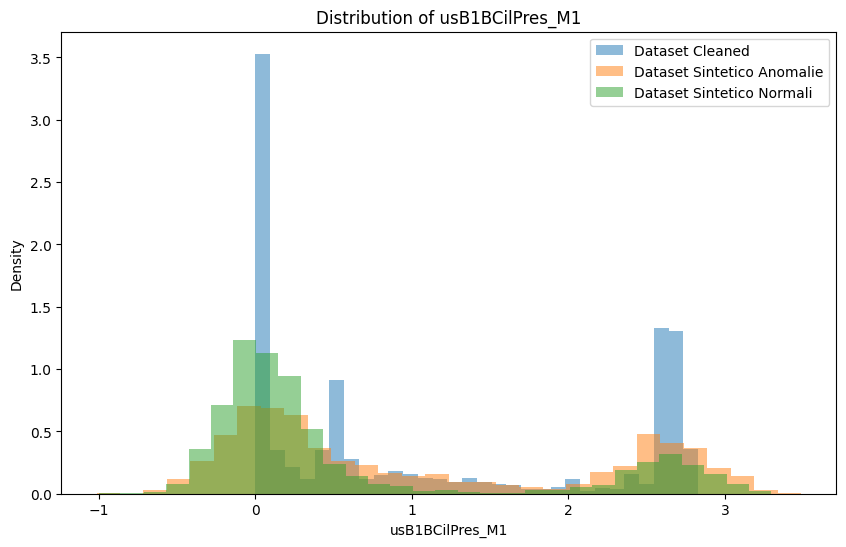

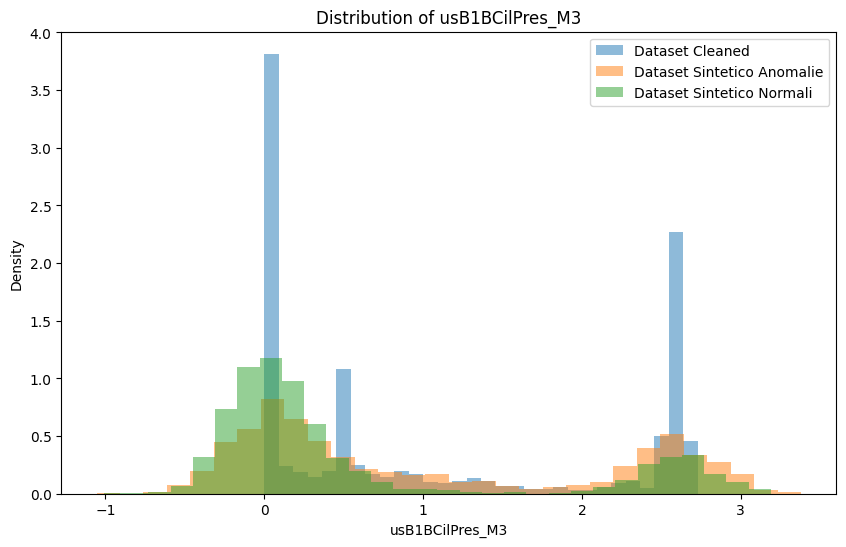

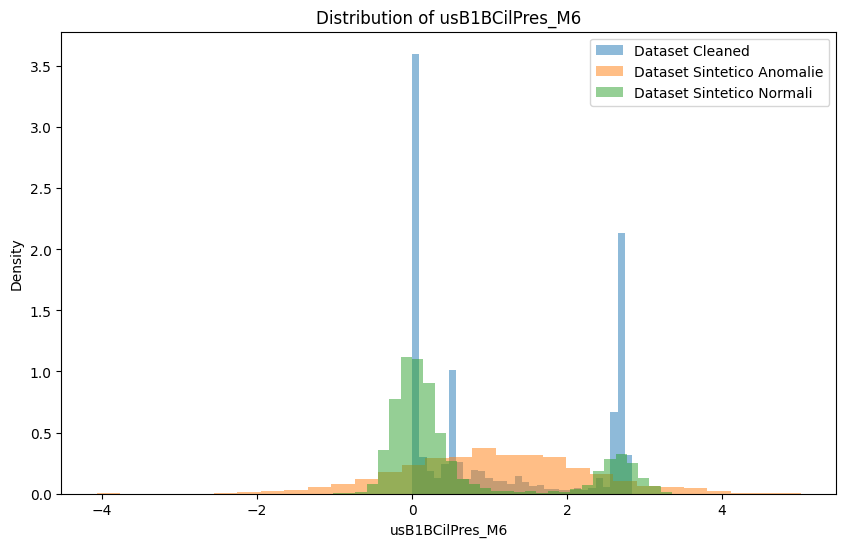

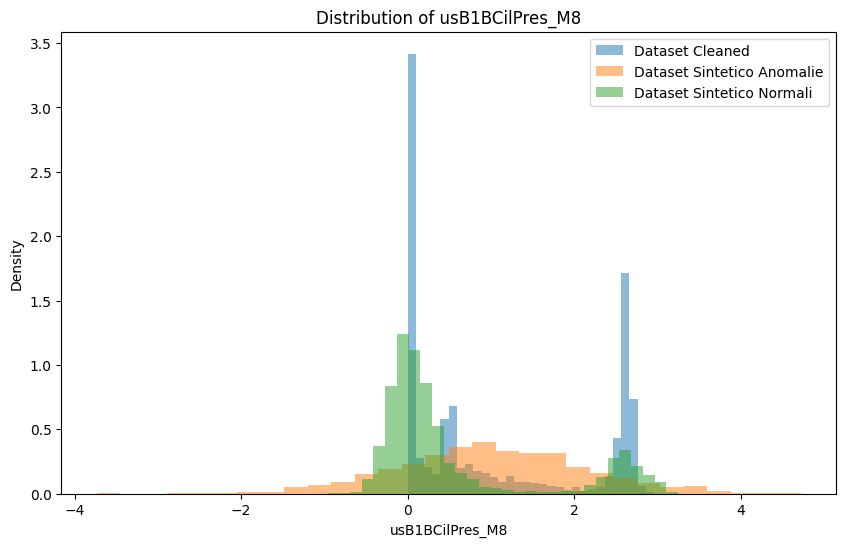

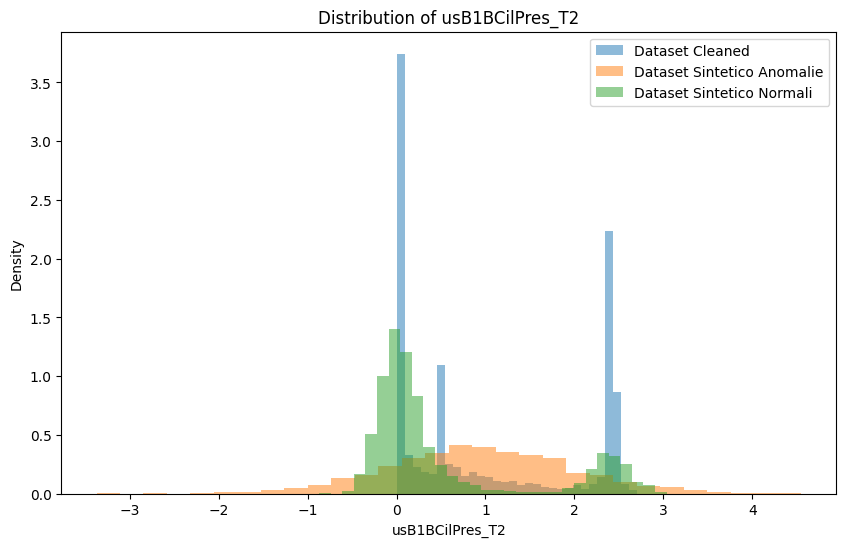

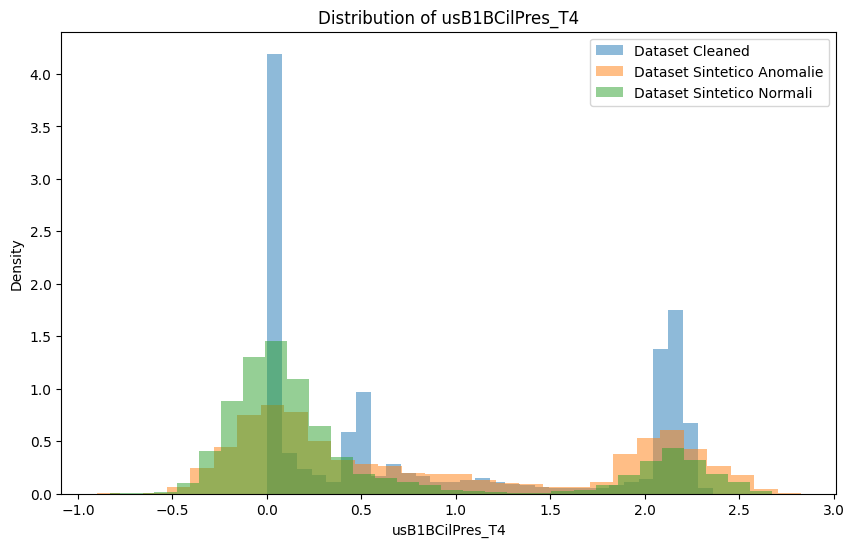

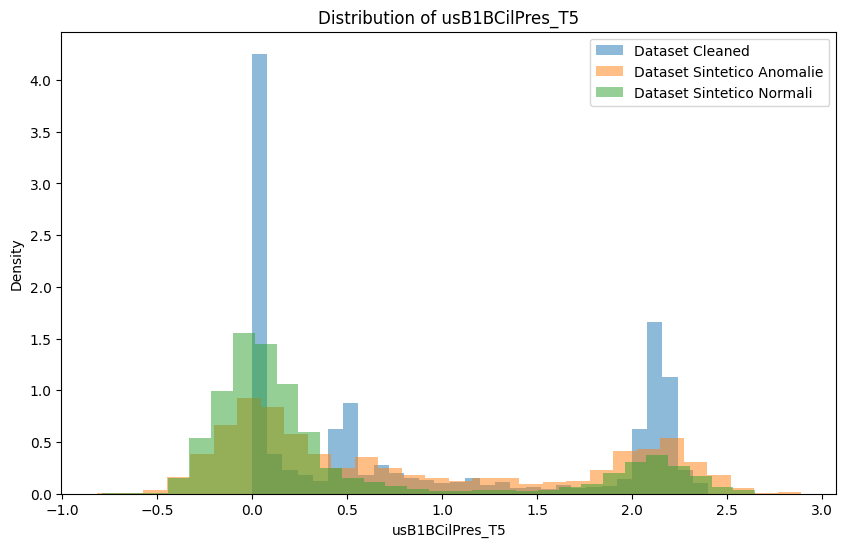

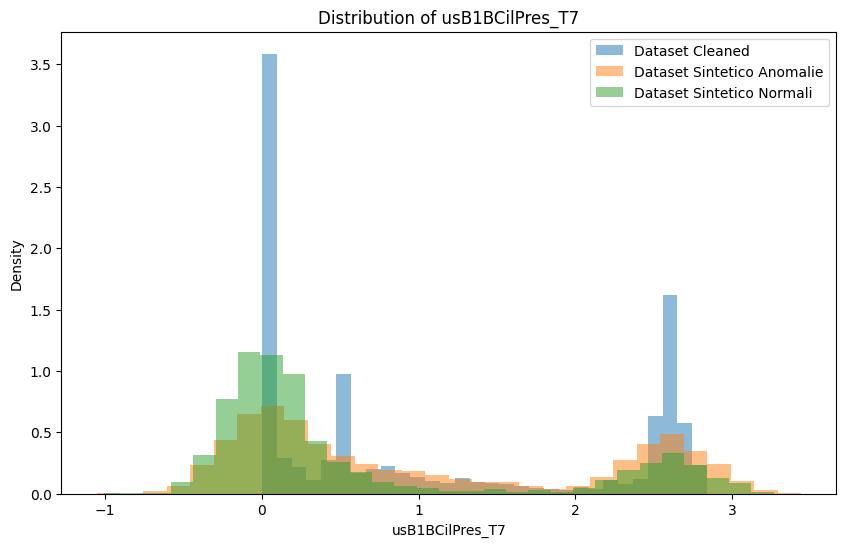

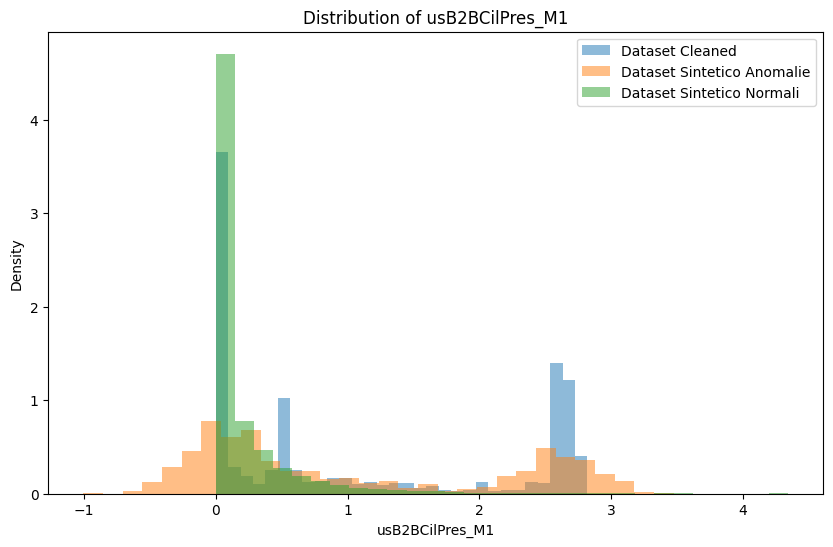

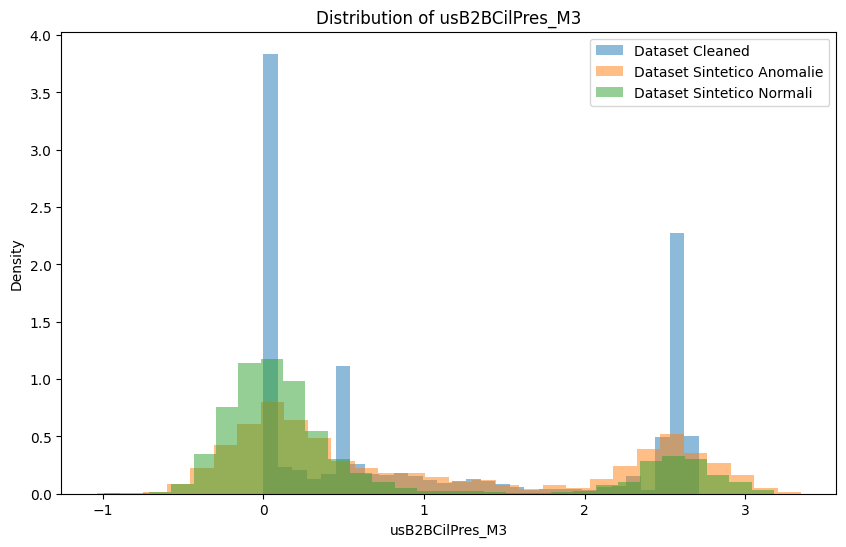

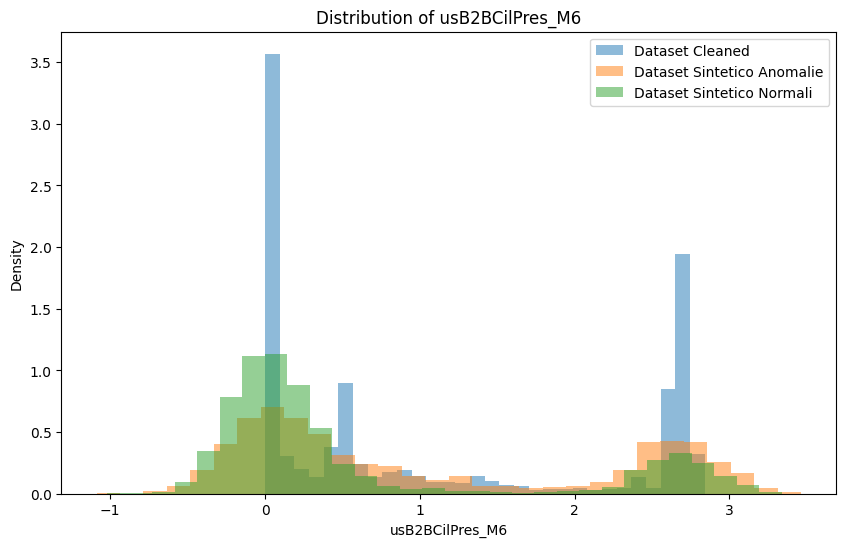

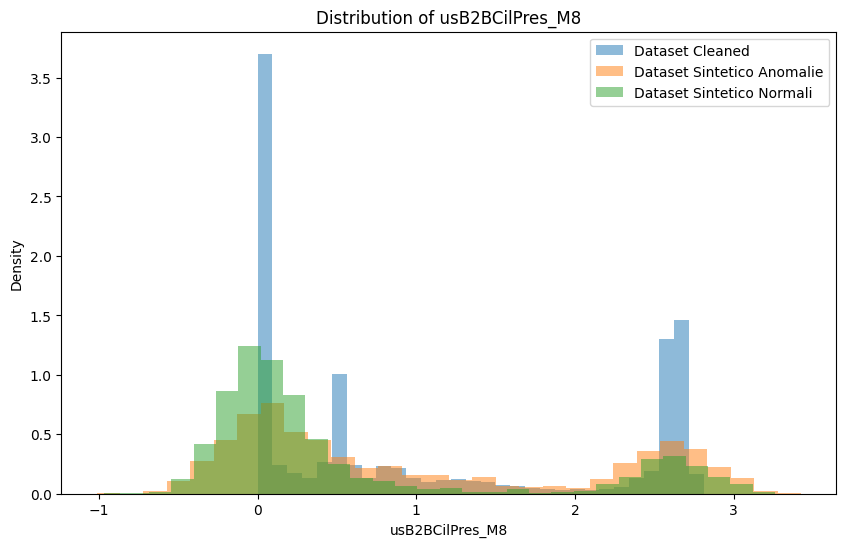

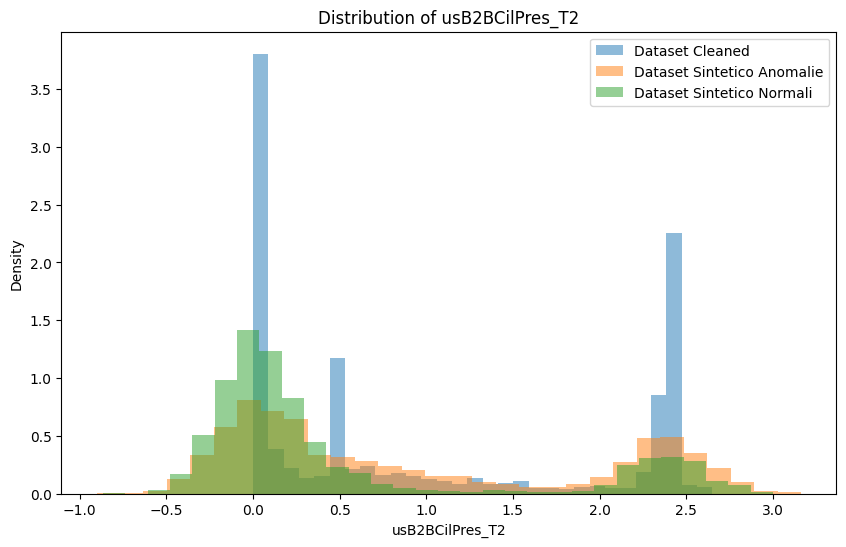

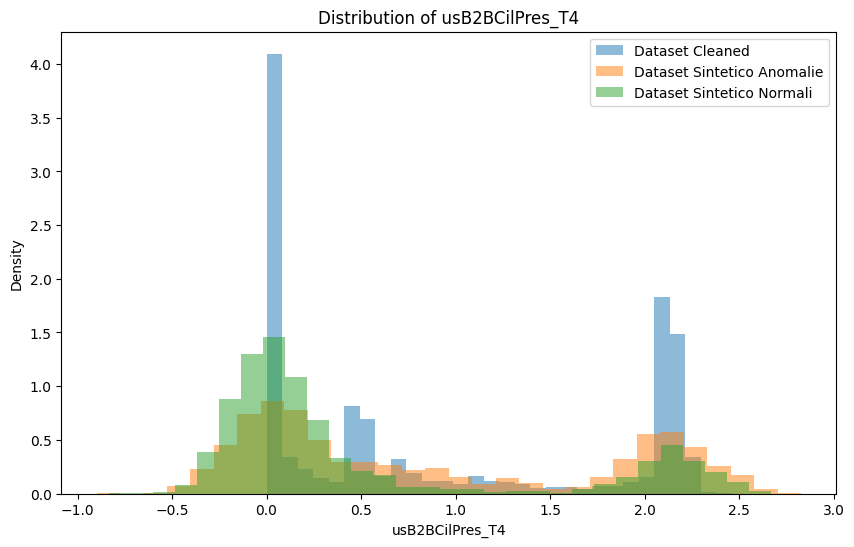

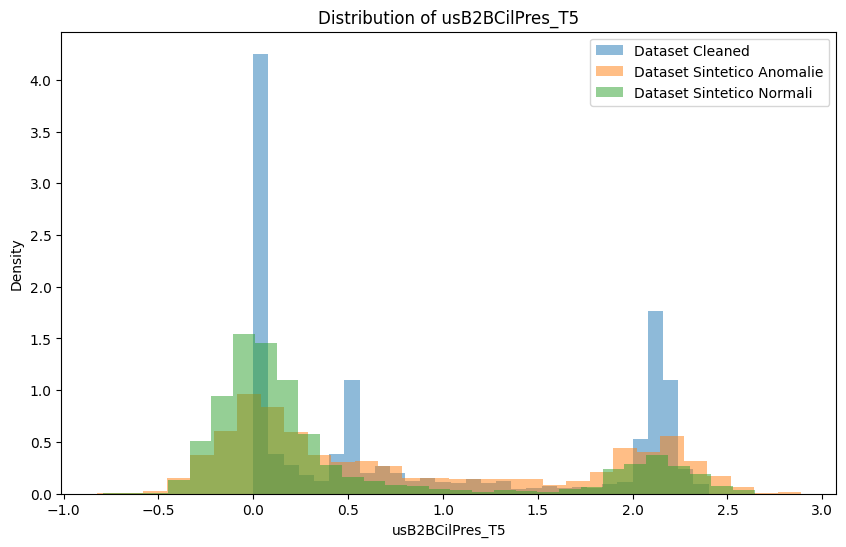

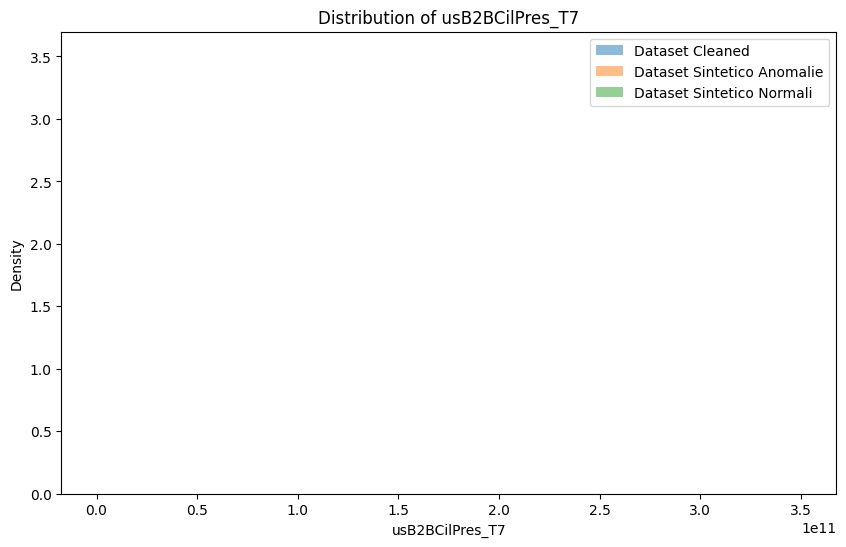

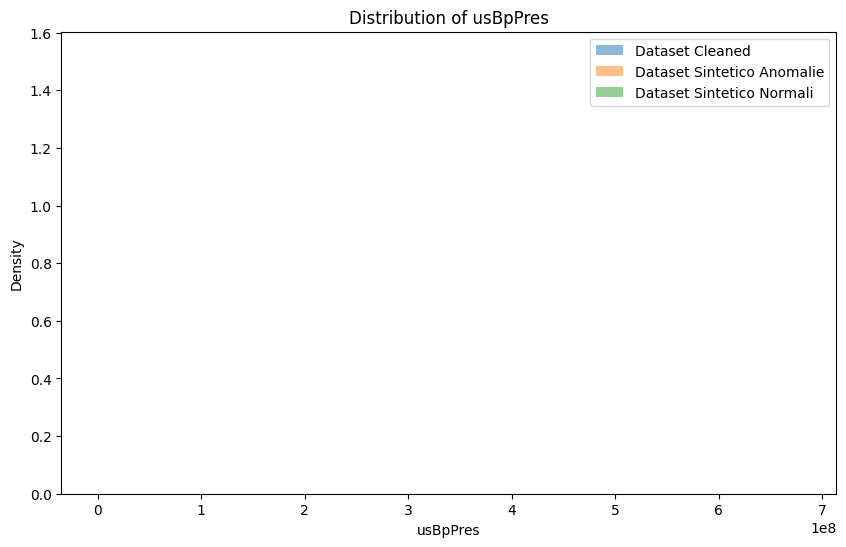

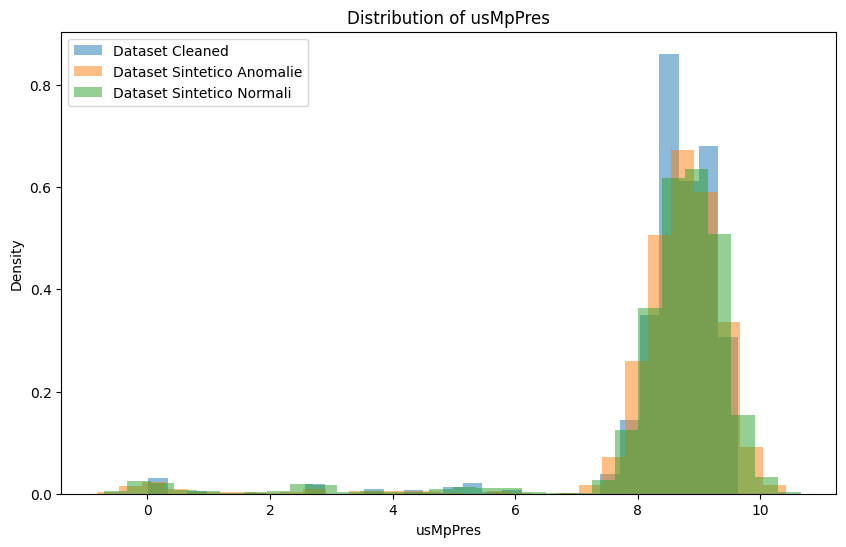

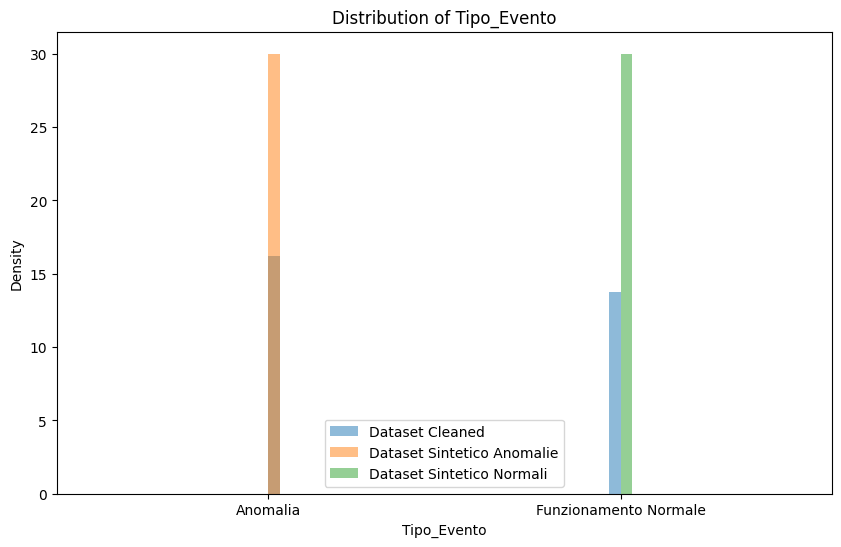

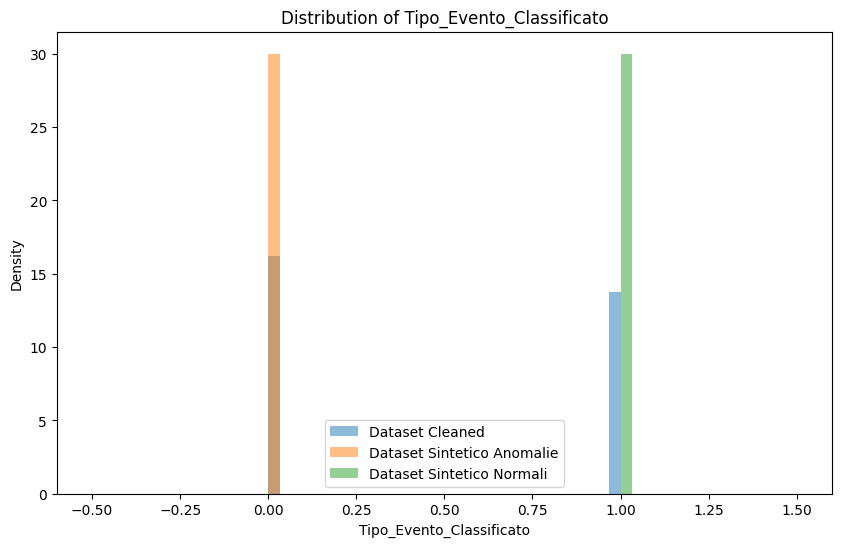

In [36]:
#rappresentazione grafica delle distribuzioni
dataset_cleaned = pd.read_csv('dataset_cleaned.csv')
dataset_sintetico_anomalie = pd.read_csv('dataset_sintetico_anomalie.csv')
dataset_sintetico_normali = pd.read_csv('dataset_sintetico_normali.csv')

common_columns = dataset_sintetico_anomalie.columns.intersection(dataset_sintetico_normali.columns)

filtered_dataset_cleaned = dataset_cleaned[common_columns]

plt.rcParams["figure.figsize"] = (10, 6)

for column in common_columns:
    plt.figure()
    plt.hist(filtered_dataset_cleaned[column].dropna(), bins=30, alpha=0.5, label='Dataset Cleaned', density=True)
    plt.hist(dataset_sintetico_anomalie[column].dropna(), bins=30, alpha=0.5, label='Dataset Sintetico Anomalie', density=True)
    plt.hist(dataset_sintetico_normali[column].dropna(), bins=30, alpha=0.5, label='Dataset Sintetico Normali', density=True)
    
    plt.title(f'Distribution of {column}')
    plt.xlabel(column)
    plt.ylabel('Density')
    plt.legend()
    plt.show()


In [ ]:
#script per la generazione continua di dati sintetici
import pandas as pd
import numpy as np
import time
from concurrent.futures import ThreadPoolExecutor
from copulas.multivariate import GaussianMultivariate
import warnings
import os
from datetime import timedelta
from random import uniform

columns_to_generate = [
    'Durata', 'CabEnabled_M1', 'CabEnabled_M8', 'ERTMS_PiastraSts', 'HMI_ACPntSts_T2', 'HMI_ACPntSts_T7',
    'HMI_DCPntSts_T2', 'HMI_DCPntSts_T7', 'HMI_Iline', 'HMI_Irsts_T2', 'HMI_Irsts_T7', 'HMI_VBatt_T2',
    'HMI_VBatt_T4', 'HMI_VBatt_T5', 'HMI_VBatt_T7', 'HMI_Vline', 'HMI_impSIL', 'LineVoltType', 'MDS_LedLimVel',
    'MDS_StatoMarcia', '_GPS_LAT', '_GPS_LON', 'ldvvelimps', 'ldvveltreno', 'usB1BCilPres_M1', 'usB1BCilPres_M3',
    'usB1BCilPres_M6', 'usB1BCilPres_M8', 'usB1BCilPres_T2', 'usB1BCilPres_T4', 'usB1BCilPres_T5', 'usB1BCilPres_T7',
    'usB2BCilPres_M1', 'usB2BCilPres_M3', 'usB2BCilPres_M6', 'usB2BCilPres_M8', 'usB2BCilPres_T2', 'usB2BCilPres_T4',
    'usB2BCilPres_T5', 'usB2BCilPres_T7', 'usBpPres', 'usMpPres'
]

all_columns = [
    'Flotta', 'Veicolo', 'Codice', 'Nome', 'Descrizione', 'Test', 'Timestamp', 'Timestamp chiusura', 'Durata', 
    'Posizione', 'Sistema', 'Componente', 'Latitudine', 'Longitudine', 'Contemporaneo', 'Timestamp segnale'
] + columns_to_generate + ['Tipo_Evento', 'Tipo_Evento_Classificato']

timestamp_iniziale = pd.Timestamp.now()

def rigeneraDatasetSintetico(file_anomalie, file_normali, df_anomalie, df_normali, num_righe):
    warnings.filterwarnings("ignore", category=RuntimeWarning)
    
    df_anomalie_copula = df_anomalie.drop(columns=['Durata'], errors='ignore')
    df_normali_copula = df_normali.drop(columns=['Durata'], errors='ignore')
    
    copula_anomalie = GaussianMultivariate()
    copula_anomalie.fit(df_anomalie_copula)
    synthetic_anomalie = copula_anomalie.sample(num_righe // 2)

    copula_normali = GaussianMultivariate()
    copula_normali.fit(df_normali_copula)
    synthetic_normali = copula_normali.sample(num_righe // 2)
    
    alpha = 0.2
    beta = 1.9
    media_durata_anomalie = 157 * alpha
    media_durata_normali = 115 * alpha
    sigma_anomalie = 1 * beta
    sigma_normali = 1 * beta

    synthetic_anomalie['Durata'] = np.random.lognormal(mean=np.log(media_durata_anomalie), sigma=sigma_anomalie, size=len(synthetic_anomalie))
    synthetic_normali['Durata'] = np.random.lognormal(mean=np.log(media_durata_normali), sigma=sigma_normali, size=len(synthetic_normali))

    for df in [synthetic_anomalie, synthetic_normali]:
        df['Flotta'] = 'ETR700'
        df['Veicolo'] = 'e700_4801'
        df['Test'] = 'N'
        df['Timestamp'] = pd.Timestamp.now()
        df['Timestamp chiusura'] = df['Timestamp'] + pd.to_timedelta(df['Durata'], unit='s')
        df['Posizione'] = np.nan
        df['Sistema'] = 'VEHICLE'
        df['Componente'] = 'VEHICLE'
        df['Timestamp segnale'] = np.nan

    for col in all_columns:
        if col not in synthetic_anomalie.columns:
            synthetic_anomalie[col] = np.nan
        if col not in synthetic_normali.columns:
            synthetic_normali[col] = np.nan

    synthetic_anomalie = synthetic_anomalie.round(2)
    synthetic_normali = synthetic_normali.round(2)

    synthetic_anomalie = synthetic_anomalie[all_columns]
    synthetic_normali = synthetic_normali[all_columns]

    synthetic_anomalie.to_csv(file_anomalie, index=False)
    synthetic_normali.to_csv(file_normali, index=False)

    warnings.filterwarnings("default", category=RuntimeWarning)
    print(f"Dataset sintetici rigenerati: {file_anomalie} e {file_normali}")

def aggiungoRigaAlFileDiDestinazione(file_output, file_anomalie, file_normali):
    global timestamp_iniziale

    if np.random.rand() < 0.5:
        dataset_file = file_anomalie
        tipo_evento = 'Anomalia'
        tipo_evento_classificato = 0
    else:
        dataset_file = file_normali
        tipo_evento = 'Funzionamento Normale'
        tipo_evento_classificato = 1

    dataset_sintetico = pd.read_csv(dataset_file)
    nuova_riga = dataset_sintetico.iloc[0].copy()
    dataset_sintetico = dataset_sintetico.iloc[1:]

    nuova_riga['Timestamp'] = timestamp_iniziale
    nuova_riga['Timestamp chiusura'] = timestamp_iniziale + pd.to_timedelta(nuova_riga['Durata'], unit='s')
    nuova_riga['Timestamp segnale'] = timestamp_iniziale + timedelta(seconds=uniform(0, 1))

    nuova_riga['Tipo_Evento'] = tipo_evento
    nuova_riga['Tipo_Evento_Classificato'] = tipo_evento_classificato

    if not os.path.exists(file_output):
        nuova_riga.to_frame().T.to_csv(file_output, mode='a', header=all_columns, index=False)
    else:
        nuova_riga.to_frame().T.to_csv(file_output, mode='a', header=False, index=False)

    dataset_sintetico.to_csv(dataset_file, index=False)

    timestamp_iniziale = pd.Timestamp.now()
    print(f"Riga sintetica aggiunta dal dataset {tipo_evento}")

def generazioneContinuataDataset(file_output, file_anomalie, file_normali, df_anomalie, df_normali, soglia=100, num_righe_rigenerazione=1000):
    executor = ThreadPoolExecutor(max_workers=2)
    rigenerazione_in_corso = None
    
    while True:
        dataset_anomalie = pd.read_csv(file_anomalie)
        dataset_normali = pd.read_csv(file_normali)

        if (len(dataset_anomalie) < soglia or len(dataset_normali) < soglia) and rigenerazione_in_corso is None:
            rigenerazione_in_corso = executor.submit(
                rigeneraDatasetSintetico, file_anomalie, file_normali, df_anomalie, df_normali, num_righe_rigenerazione
            )
            print("Rigenerazione del dataset sintetico avviata in parallelo.")

        durata = dataset_anomalie.iloc[0].get('Durata', 1) if np.random.rand() < 0.5 else dataset_normali.iloc[0].get('Durata', 1)
        time.sleep(durata)
        aggiungoRigaAlFileDiDestinazione(file_output, file_anomalie, file_normali)

        if rigenerazione_in_corso and rigenerazione_in_corso.done():
            print("Rigenerazione completata.")
            rigenerazione_in_corso = None

df_originale = pd.read_csv('dataset_cleaned.csv')
df_anomalie = df_originale[df_originale['Tipo_Evento'] == 'Anomalia']
df_normali = df_originale[df_originale['Tipo_Evento'] == 'Funzionamento Normale']

columns_to_check = ['Descrizione', 'Timestamp', 'Codice', 'Nome']
df_deduplicated_anomalies = df_anomalie.loc[(df_anomalie[columns_to_check] != df_anomalie[columns_to_check].shift()).any(axis=1)]
df_deduplicated_normals = df_normali.loc[(df_normali[columns_to_check] != df_normali[columns_to_check].shift()).any(axis=1)]

rigeneraDatasetSintetico('dataset_sintetico_anomalie.csv', 'dataset_sintetico_normali.csv', df_deduplicated_anomalies[columns_to_generate], df_deduplicated_normals[columns_to_generate], num_righe=1000)

generazioneContinuataDataset('dataset_destinazione.csv', 'dataset_sintetico_anomalie.csv', 'dataset_sintetico_normali.csv', df_deduplicated_anomalies[columns_to_generate], df_deduplicated_normals[columns_to_generate])


Dataset sintetici rigenerati: dataset_sintetico_anomalie.csv e dataset_sintetico_normali.csv
Riga sintetica aggiunta dal dataset Funzionamento Normale
Riga sintetica aggiunta dal dataset Anomalia
Riga sintetica aggiunta dal dataset Anomalia
Riga sintetica aggiunta dal dataset Funzionamento Normale
Riga sintetica aggiunta dal dataset Anomalia
Riga sintetica aggiunta dal dataset Funzionamento Normale
Riga sintetica aggiunta dal dataset Funzionamento Normale
Riga sintetica aggiunta dal dataset Funzionamento Normale
Riga sintetica aggiunta dal dataset Funzionamento Normale
Riga sintetica aggiunta dal dataset Funzionamento Normale
Riga sintetica aggiunta dal dataset Funzionamento Normale
Riga sintetica aggiunta dal dataset Funzionamento Normale
Riga sintetica aggiunta dal dataset Anomalia
Riga sintetica aggiunta dal dataset Funzionamento Normale
Riga sintetica aggiunta dal dataset Funzionamento Normale
Riga sintetica aggiunta dal dataset Funzionamento Normale
Riga sintetica aggiunta dal dat

In [1]:
#test del modello sui dati sintetici
train_columns = X_final.columns

df_sintetico = pd.read_csv('dataset_destinazione.csv')

X_sintetico = df_sintetico[train_columns]
y_sintetico = df_sintetico['Tipo_Evento_Classificato'].replace({1: 'Funzionamento Normale', 0: 'Anomalia'})

y_pred_sintetico = rf_model.predict(X_sintetico)

accuracy_sintetico = accuracy_score(y_sintetico, y_pred_sintetico)
classification_rep_sintetico = classification_report(y_sintetico, y_pred_sintetico, target_names=['Anomalia', 'Funzionamento Normale'])

print(f"Accuratezza del modello sui dati sintetici: {accuracy_sintetico:.4f}")
print("Report di classificazione sui dati sintetici:")
print(classification_rep_sintetico)


NameError: name 'X_final' is not defined